<a href="https://colab.research.google.com/github/leedh/TIL/blob/master/RSA_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Representational Similarity Analysis
By <a href="http://markallenthornton.com/">Mark A. Thornton, Ph.D</a>

## What is representational similarity analysis?

Representational similarity analysis (RSA) is statistical technique based on analyzing second-order isomorphisms. That is, rather than directly analyzing the relationship between one measure and another, RSA instead computes some measure of similarity within each measure and then compares these similarities to each other. Although techniques correlating distance matrices have existed for some time in other fields, such as ecology, RSA proper was pioneered by  [Kriegeskorte, Mur, and Bandettini (2008, Frontiers in System Neuroscience)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2605405/) and has since become a popular method for analyzing neuroimaging data. Much of this popularity is driven by the fact that - because RSA focuses on second-order isomorphisms (i.e., similarities) - it is an incredibly flexible analytic technique, capable of linking disparate measures of brain and behavior.

![Kriegeskorte, Mur, and Bandettini (2008)](https://mysocialbrain.org/misc/data/rsa_workshop/rsa.gif)

## This RSA workshop

This workshop will take a deep dive into the principles and practice of RSA in social neuroscience and allied subfields. Key topics covered will include: designing fMRI studies suitable for RSA; preparing brain data for RSA; measures of similarity, and when to apply them; bivariate and multivariate approaches for comparing similarity matrices to each other; null hypothesis significance testing for RSA; effects sizes and noise ceiling estimation; cross-validation and model selection; and visualizing representational similarities. Examples will highlight how RSA can connect different types of data, including self-report, behavior, computational models, text, and fMRI.

The organization of this workshop can be seen in the table of contents on the left side of the Google Colab window (if this sidebar is not currently open, click the icon with three dots/horizontal lines to open the table of contents). The workshop will be organized into four main sections:

1. **Introduction** - the present section, introducing the workshop and featuring our first RSA.
2. **Measuring similarity** - a consideration of the various methods for estimating (dis)similarities.
3. **Comparing similarity matrices** - an exploration of the various ways to compare similarity matrices to each other, and how to perform significance testing, calculate effect sizes, and cross-validate such models.
4. **Visualization and fMRI considerations** - this section examines exploratory techniques - including visualization - for discovering structure in similarity data. It also addresses issues specific to fMRI.

Before we got any further, please execute the cell below to load all of the packages we will need for the rest of the workshop. You can execute cells in Jupyter Notebooks (which is what Google Colab hosts) using the Crtl+Enter shortcut. You may prefer the Shift+Enter shortcut instead, since it executes *and* moves to the next cell.

In [ ]:
!pip install umap-learn
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform
from scipy.stats import kendalltau, entropy, ttest_1samp
import statsmodels.api as sm
from sklearn.manifold import MDS
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
from sklearn import manifold

     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 1.2MB 41.9MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=e33e37a51c83c787398a5a8e7d586a9f0313c6e3323cefd19bbbfd23c63b8a96
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=b287d20391c993be9811a1605dc3095b81b7a2284dbd46bd7fa2a1a24c6c061f
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Running our first RSA

Let's start by conducting our first representational similarity analysis together! This simple example will illustrate the key steps in the process, thus providing context for the more detailed considerations in subsequent sections.

The data we will examine in this section comes from [Thornton & Mitchell 2018 (Cerebral Cortex)](http://markallenthornton.com/cv/Thornton&Mitchell_CC_2017.pdf), a study in which we examined how the brain organizes its representations of other people. Participants made a range of inferences about the thoughts and feelings of 60 carefully selected public figures. The schematic below illustrates the basic design. 

![](https://mysocialbrain.org/misc/data/rsa_workshop/CC_design.png)

After preprocessing, we used the general linear model (GLM) to effectively average across each presentation of a given target person. This allowed us to estimate stable patterns of brain activity associated with each person. If you're curious, you can view wholebrain patterns (averaged across participants) at the bottom of [this](http://markallenthornton.com/blog/celebrities-on-the-brain/) post on my blog. Using a process called [reliability-based feature selection](https://www.sciencedirect.com/science/article/pii/S1053811919309413), we determined that the regions shown in the image below contained maximally reliable voxelwise and patternwise neural representations of the target people. The regions closely resemble regions [habitually implicated](https://neurosynth.org/analyses/terms/social/) in a broad variety of fMRI studies of social cognition, including dorsal and ventral medial prefrontal cortex, medial parietal cortex, the temporoparietal junction, and the anterior temporal lobe.

![](https://mysocialbrain.org/misc/data/rsa_workshop/brain_rel.png)

We extracted target person-specific contrast patterns from each participant's brain within these regions, z-scored the voxels across target, and then computed the similarity between the patterns by (Pearson) correlating them. We'll discuss the merits of using correlations vs. other measures to estimate similarity in the next section.

The result of this process was a 60 x 60 neural pattern similarity (i.e., correlation) matrix for each participant. We extracted the non-redundant part of this matrix - the lower (or upper) triangular component - and vectorized it. The vectorized matrices form the columns of the data we load in the cell below.

In [ ]:
# read in data from URL
ndat = pd.read_csv('http://scraplab.org/data/rsa_workshop/neural_pattern_similarity.csv')

# print shape (row and column numbers)
print(ndat.shape)

# print first five rows
ndat.head()

(1770, 29)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29
0,-0.187855,-0.031095,0.178634,0.032656,0.075958,-0.145326,-0.252845,0.034909,-0.097057,-0.192317,-0.181035,-0.106029,0.185672,0.144315,-0.140651,-0.261469,0.081052,0.031175,-0.394998,-0.075793,-0.220901,0.447043,-0.170573,-0.097976,0.220705,0.026900,0.044298,0.079184,0.124191
1,0.269922,-0.259500,-0.080621,-0.143283,-0.093804,0.073850,0.119089,-0.042587,0.025690,0.172289,-0.079589,-0.287631,0.103886,0.049219,0.018768,0.262880,-0.265027,0.140856,0.067444,0.038459,0.058122,0.040864,-0.044574,0.103323,0.232834,0.049057,-0.152629,0.031662,-0.042271
2,-0.362848,0.277269,-0.016923,-0.237905,-0.037020,0.193435,-0.129116,0.094469,0.180872,0.055979,0.136129,0.097077,0.150711,0.029844,0.372887,0.122462,-0.134249,-0.247800,-0.379091,-0.194663,0.100582,0.143879,-0.144859,0.118228,0.002970,-0.041163,-0.097689,-0.122934,0.036744
3,-0.090603,-0.411761,-0.430705,0.049699,0.491499,0.167924,0.044502,-0.001298,0.007262,-0.210055,0.053443,0.014170,0.215430,0.142389,-0.283890,0.280766,-0.119818,-0.424975,0.157834,-0.067047,-0.040911,-0.293797,0.370638,-0.216370,-0.332915,0.011372,-0.237155,0.181859,-0.069653
4,0.133942,0.177825,-0.205402,0.014339,0.122916,0.056498,0.032094,0.015853,0.243319,0.021028,0.156967,0.127696,0.033732,0.156014,-0.332835,0.064633,-0.208454,-0.030507,-0.128295,-0.115495,0.128453,0.020809,-0.309467,0.201250,0.139760,-0.001879,0.097616,-0.082745,-0.194093


To keep things simple for this initial example, let's work with a single similarity matrix. We could extract the matrix of any of the 29 participants as a column from the "ndat" dataframe, but instead let's average across these participants to produce a single group-level (vectorized) neural similarity matrix. To weight the participants evenly, we'll z-score the columns before averaging the rows. In the third section, we will discuss the pros and cons of this approach.

In [ ]:
# z-score using scipy function
# note that we need to change default degrees of freedom to get the sample SD
zndat = zscore(ndat,ddof=1)

# take mean along the rows
nsim = zndat.mean(axis=1)
nsim.shape

(1770,)

Now that we have our neural data ready for analysis, we need something to compare it to. As we'll see later, in the paper we compared it to predictions made from the dimensions of several theories of person perception. But again, let's keep thing simple to start with. A large group of Mturk raters provided us with explicit ratings of how similar they thought each of the target people were to each other. Let's load that data in now to use as a model for the neural similarity data.



In [ ]:
# read in the data
holdat = pd.read_csv('http://scraplab.org/data/rsa_workshop/holdists.csv')

# the first column contains the ratings
rsim = holdat.holistic

# the ratings are reverse-coded as dissimilarities, so let's fix that
rsim = 100-rsim
rsim

0       29.776389
1       40.637500
2       32.700000
3       70.700000
4       60.471825
          ...    
1765    40.450000
1766    62.861111
1767    29.632540
1768    63.989683
1769    41.503968
Name: holistic, Length: 1770, dtype: float64

Finally, we'll conduct the representational similarity analysis itself. In this case, we'll do that by computing the bivariate (Pearson) correlation between the neural similarities and the rated similarities, but in the third section we'll explore other ways to do this.

In [ ]:
# compute the correlation
np.corrcoef(nsim,rsim)[0,1]

0.3994679727516274

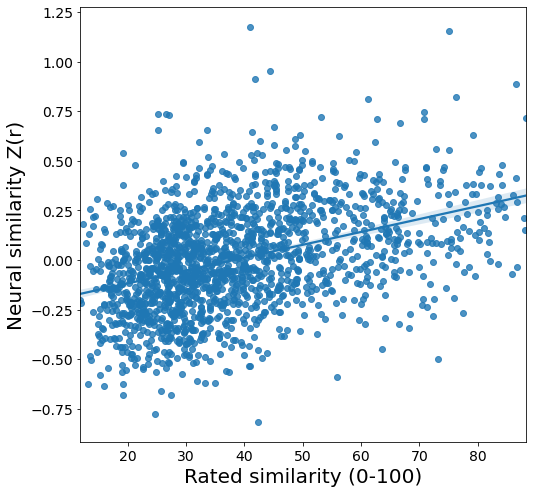

In [ ]:
# generate a scatterplot to go with it
plt.figure(figsize=(8, 8))
fig = sns.regplot(x=rsim,y=nsim)
fig.set_xlabel('Rated similarity (0-100)',fontsize=20)
fig.set_ylabel('Neural similarity Z(r)',fontsize=20)
fig.tick_params(labelsize=14)

As we can see, there is a moderate correlation (r = .40) between Mturk raters similarity judgments and the similarity of neural activity patterns. As we'll see later, this correlation is statistically significant. However, the confidence interval in the plot above is overly optimistic because it assumes that each data point is independent - an assumption that is violated by the structure of similarity matrices.

Now that we have seen a basic example of representational similarity analysis, let's go through all of the steps in more detail!

# Measuring similarity

One of the most important decisions in RSA is how you will measure the similarity between your conditions/observations. Let's start with some terminology:



*   **Similarity**: any measure of how similar two conditions/observations are to each other
*   **Dissimilarity**: reverse-coded similarity. Similarities can be turned into dissimilarities by flipping their sign (or subtracting them from a constant). Other than this sign flip, there is no substantial difference, but sometimes it is easier to think in terms of or interpret dissimilarities instead of similarities (or vice versa).
* **Distances**: Some dissimilarities belong to the more specific subclass known as distances. [Distance metrics](https://en.wikipedia.org/wiki/Metric_(mathematics) are mathematically defined, and to qualify a function must satisfy several axioms such as the triangular inequality. The ubiquity of distance metrics in statistical software is one reason why people often prefer to speak in terms of dissimilarities rather than similarities. However, like any other dissimilarity measure, distances can be reverse-coded into similarities if desired.



## Basic similarity measures

Although there are a huge number of possible similarity measures we could apply to any data, some are far more commonly used than others. These include mean difference, Euclidean distance, and correlation. Let's start by exploring these basic similarity measures. 

To make the differences between these measures stand out, we'll use some simulated data that we will generate in the cell below.

In [ ]:
# generate multivariate normal data
np.random.seed(1)
sigmat = np.asarray((1,0,.8,0,0,1,0,.8,.8,0,1,0,0,.8,0,1))
sigmat.shape = (4,4)
fakedat = np.random.multivariate_normal([0, 0, 1, 1], sigmat, 200)

Text(0, 0.5, 'Activity')

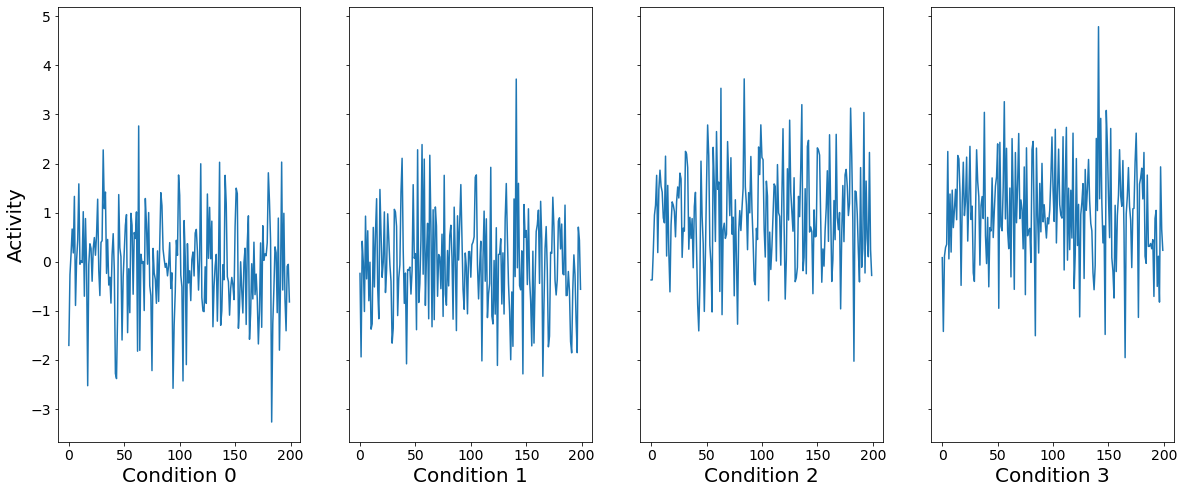

In [ ]:
# plot simulated "activity patterns"
fig, axs = plt.subplots(1, 4, sharex=True, sharey=True,figsize=(20, 8))
for i in range(4):
  sns.lineplot(x=range(200),y=fakedat[:,i],ax=axs[i])
  axs[i].set_xlabel('Condition ' + str(i),fontsize=20)
  axs[i].tick_params(labelsize=14)
axs[0].set_ylabel('Activity',fontsize=20)

### Mean difference

Mean difference measures the similarity between conditions by comparing their average value across conditions. This measure is very rarely for RSA on fMRI data, because it deliberately discards one of the features that makes RSA an interesting tool for fMRI analysis: its sensitivity to the fine grained patterns of activity *across* voxels. Conducting RSA using mean pattern activity differences is thus very similar to doing a standard univariate ROI analysis. This can be useful for comparisons purposes - such as demonstrating whether patterns contain different information than the mean - but it is seldom a good choice for one's primary similarity measure.

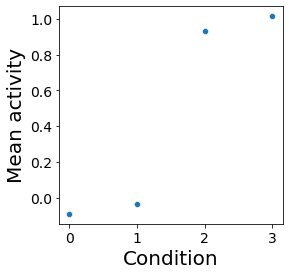

In [ ]:
# compute mean for each "condition"
cmeans = np.mean(fakedat,axis=0)

# plot condition means
plt.figure(figsize=(4, 4))
fig = sns.scatterplot(x=range(4),y=cmeans)
fig.set_xlabel('Condition',fontsize=20)
fig.set_ylabel('Mean activity',fontsize=20)
fig.tick_params(labelsize=14)

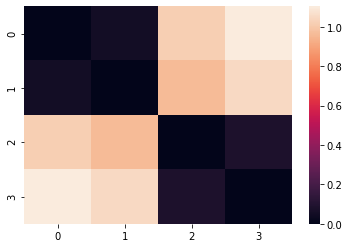

In [ ]:
# compute differences between them (Euclidean distance = absolute difference for 1d)
cmeans.shape = (4,1)
mdists = pdist(cmeans)

# visualize distances
sns.heatmap(squareform(mdists))

As you can see in the heatmap above, the distance between conditions is determined entirely by their means: conditions 0 and 1 are close to each other, as are 2 and 3, but 0 and 1 are very different from 2 and 3.

### Euclidean distance

Euclidean distance is the distance measure we're probably all most familiar with. This is because we exist the physical space we live in is generally well-described by 3d Euclidean geometry. Unlike mean difference, Euclidean distance is sometimes actually used in representational similarity analyses. The nominal dimensionality of fMRI data is defined by the number of voxels being analyzed, and is thus usually much higher dimensional than our spatial world. However, the true (instrinic) dimensionality of fMRI data is usually much lower than the number of voxels due to spatial dependency between nearby voxels.

Computation of Euclidean distance is very simple: it is equivalent to the square root of the summed squared elementwise differences between two vectors. Let's calculate one such difference below, and then use the pdist function to compute all the differences between our four simulated conditions.

17.7112193640077
[17.71121936 16.84557212 23.36551427 22.72029544 17.23364474 18.11639444]


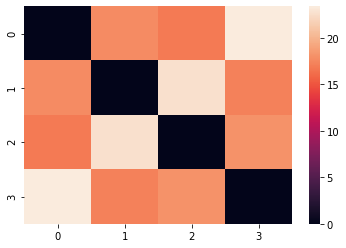

In [ ]:
# compute the Euclidean distance between conditions 0 and 1 "manually" 
print( np.sum((fakedat[:,0]-fakedat[:,1])**2)**(.5) )

# compute all Euclidean distances using pdist (Euclidean is the default metric)
edists = pdist(fakedat.T)
print(edists)

# visualize distances
sns.heatmap(squareform(edists))

As we can see in the heatmap above, the distances depend on more than just the condition mean. Euclidean distance is sensitive to both mean differences between conditions, and the pattern of activity across voxels. This makes it effectively an intermediate measure between mean difference and correlation.

Note that - for mathematical convenience (squares add together in ways that their roots do not) - it is not uncommon to see the use of squared Euclidean distance instead of Euclidean distance per se.

### Correlation

Correlation, and Pearson correlation in particular, is the most common measure similarity used in RSA on fMRI data. Correlations are similarity measures by default, but correlation distance can be easily computed as 1-r. On this scale, a perfect correlation (r = 1) leads to a distance of 0, whereas perfect anti-correlation (r = -1) leads to a distance of 2. Despite the term "correlation *distance*," correlations do not satisfy the triangular inequality, and are thus not true distance metrics. Correlations are standardized covariances, and as a result, they do not reflect either the variances of the patterns, nor their means. As a result, correlation and mean difference measures rely on separately information. This has been on of the main arguments in favor of correlation instead of Euclidean distance measures: the former is sensitive to the pattern of activity, but not the mean, and thus RSA using correlations has more potential reveal new/different results when compared to univariate approaches.

[0.77533465 0.18763004 0.74146965 0.79519821 0.18355522 0.78022088]


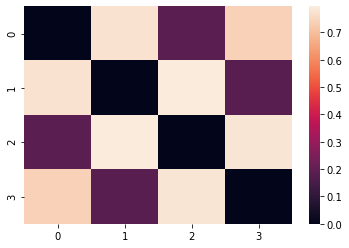

In [ ]:
# compute all Euclidean distances using pdist (Euclidean is the default metric)
cdists = pdist(fakedat.T,'correlation')
print(cdists)

# visualize distances
sns.heatmap(squareform(cdists))

As you can see in the heatmap above, the correlation distance between conditions depends entirely on the correlation between our conditions, and the means do not affect it.

Although Pearson correlation is the most commonly used version of the correlation coefficient, there are three related measures that are sometimes used in RSA: Spearman's rho, Kendall's tau, and cosine similarity. Rho and tau are both rank correlations, meaning that they are computed over the ordinal ranks of the data, rather than over the raw data. Rho is simply the Pearson correlation of the ranks. The calculations behind tau are [a bit more complicated](https://en.wikipedia.org/wiki/Kendall_rank_correlation_coefficient). Cosine similarity is - as the term "cosine" hints - a measure of angle similarity. However, mathematically it is equivalent to the Pearson correlation, if its inputs are mean-centered.

array([[1.        , 0.77553047, 0.78219772, 0.63421836],
       [0.77553047, 1.        , 0.99892438, 0.79215435],
       [0.78219772, 0.99892438, 1.        , 0.79399255],
       [0.63421836, 0.79215435, 0.79399255, 1.        ]])

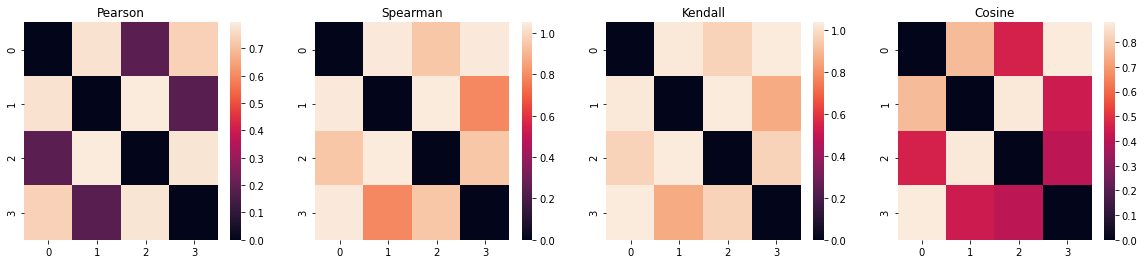

In [ ]:
# re-plot Pearson
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
sns.heatmap(squareform(cdists),ax=axs[0])
axs[0].set_title('Pearson')

# compute ranks
fakerank = fakedat.argsort(axis=0)

# compute Spearman correlations
sdists = pdist(fakerank.T,'correlation')
sns.heatmap(squareform(sdists),ax=axs[1])
axs[1].set_title('Spearman')

# compute Kendall correlations
kdists = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        kdists[i,j] = 1-kendalltau(fakerank[:,i],fakerank[:,j])[0]

sns.heatmap(kdists,ax=axs[2])
axs[2].set_title('Kendall')

# compute cosine similarity
codists = pdist(fakedat.T,'cosine')
sns.heatmap(squareform(codists),ax=axs[3])
axs[3].set_title('Cosine')

# correlations between correlation measures
np.corrcoef(np.column_stack((cdists,sdists,squareform(kdists),codists)).T)

Above you can see that these four correlation-like measures yield fairly similar results in well-behaved data. If our data was less well-behaved (e.g., highly skewed) then we would likely observe more substantial differences between them. 

Although all four measures are used to compare similarity matrices to each other (see the next major section), it is fairly rare to see neural pattern similarity computed using any correlation measure other than Pearson's.

In the heatmaps below, we can see a comparison of mean difference, Euclidean distance, and (Pearson) correlation distance that makes the similarities and differences between these measures clear.

Text(0.5, 1.0, 'Correlation')

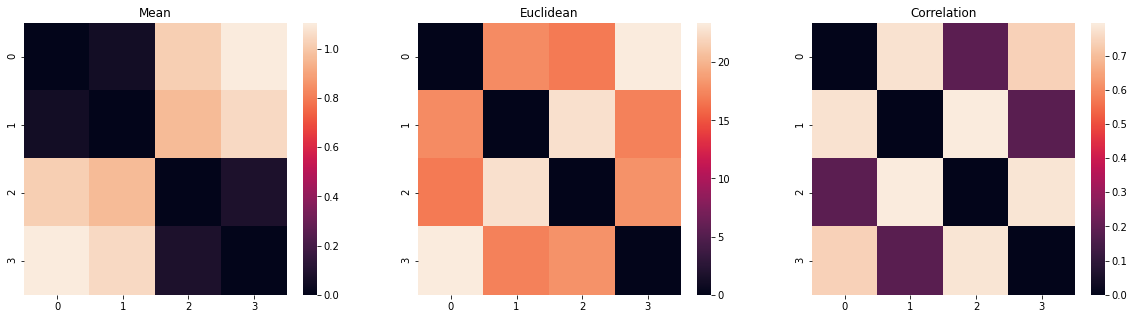

In [ ]:
# plot measures
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
sns.heatmap(squareform(mdists),ax=axs[0])
axs[0].set_title('Mean')
sns.heatmap(squareform(edists),ax=axs[1])
axs[1].set_title('Euclidean')
sns.heatmap(squareform(cdists),ax=axs[2])
axs[2].set_title('Correlation')

## Asymmetric similarity

The vast majority of RSA studies use symmetric similarities. This means that the similarity(a,b) = similarity(b,a). All distance metrics, for instance, are necessarily symmetric by definition. However, it is perfectly possible to perform RSA on asymmetric data. Doing so substantially expands the capacities of RSA, allowing it to distinguish between models that would otherwise be indistinguishable, and encode predictions about sequential dynamics in behavior or cognition.

### KL divergence

Kullback–Leibler (KL) divergence is an important measure in information theory. It reflects how different one probability distribution is from another, or in Bayesian terms, how much information is gained when updating from one distribution to another. The KL divergence has the potential to be asymmetric, reflecting the asymmetry of Bayesian updating: it requires less information to learn something new than it does to unlearn that same thing and return to a state of uncertainty. We can see this illustrated in the trivial example below:

In [ ]:
# Bernoulli distribution with equal probabilities of each outcome
# (also, discrete uniform distribution with two outcomes)
d1 = [.5, .5] 

# this is the maximum entropy (least informative) Bernoulli distribution
entropy(d1)

0.6931471805599453

In [ ]:
# Bernoulli distribution with heavily skewed outcomes (90% vs 10%)
d2 = [.9, .1] 

# this distribution has much less entropy (i.e., is very informative)
entropy(d2)

0.3250829733914482

In [ ]:
# small KL divergence when updating from d1 to d2 (learning)
print(entropy(d2,d1))

# large KL divergence when updating from d2 to d1 (unlearning)
print(entropy(d1,d2))

0.3680642071684971
0.5108256237659907


Patterns of neural activity can (arguably) be conceptualized as the outcomes of a probability distribution of activity over voxels. Thus, KL divergence can be used to compute an asymmetric measure of neural (dis)similarity. Although partially asymmetric, the upper and lower triangular components of KL divergence matrix will still tend to be fairly correlated. Subtracting the raw KL matrix from its transpose can isolate the asymmetric component specifically.

I used this approach in a [paper](https://www.jneurosci.org/content/39/1/140) a few years ago to help determine whether the social brain network encodes the transition probabilities between others' emotions, or just the the similarity of those emotions. Transitions and similarity are highly correlated in general, making these hypotheses difficult to distinguish. However, asymmetries in transitions and similarities are relatively distinguishable, so asymmetric RSA helped us resolve this question.

### Directed graph distance

Direct (network) graphs are another form in which asymmetric similarity tends to manifest. For example, the graph below illustrates a Markov chain in which transitions are much more likely in the clockwise direction around the circle, than in the counterclockwise direction or across the "face" of the clock. In this sense the "distance" from state 1 to state 2 is much less than the "distance" from state 2 to state 1. If this isn't intuitive, imagine swimming around a ring-shape pool with the current, or against it - traveling the same Euclidean distance expends much more energy in one direction than the other.

![](https://mysocialbrain.org/misc/data/rsa_workshop/alternative_models_v2.jpg)

The transitions in the graph above structured the experience of participants in one study from a manuscript we recently [preprinted](https://psyarxiv.com/kbcsj/). Participants instructed using an elaborate cover story about being a xenopsychologist on a mission to understand the mental state of a novel alien creature. We were curious to see whether the transition dynamics between these states influenced the conceptual similarity participants ascribed to them. In this particular version of the task, we were particularly interested in whether people encoded the conceptual similarity as points in a ring in a 2d space, or whether they reflected just the transition probabilities. As the lower left panel indicates, we found found a mixture of both: participants symmterized the transitions, as predicted by the geometric space, but some of the asymmetries in the transitions remained.




### Tversky index

The cognitive scientist Amos Tversky proposed another measure of similarity capable of producing asymmetric results. This measure - known as the [Tversky index](https://en.wikipedia.org/wiki/Tversky_index) - was created in an attempt to account for asymmetries in psychological judgments of similarity. For example, (separate groups of) Americans in the 70s reported that North Korea is more similar to China, than China is to North Korea. The Tversky index explains this in terms of set theory. You can check the notation in the link above, but the simple intuition is most of North Korea's features it shares with China, but fewer of China's features are shared with North Korea. Thus measuring similarity by dividing feature overlap by total features yields asymmetry.

Although valuable conceptually, the Tversky index has some free parameters that are difficult to estimate. Moreover, fMRI data do not naturally consist of features in the set theoretic sense. Thus this measure is rarely used for RSA in practice.

## Dealing with bias and noise

FMRI data - and many other forms of data you might want to perform RSA on - have inherent patterns of bias and noise that can limit reliability and/or lead to erroneous inferences. Fortunately, a number of techniques have been developed to help mitigate these issues. Most of these techniques are deployed when estimating similarity between activity patterns.

### Mean pattern subtraction

Depending on the method you used to generate activity patterns from fMRI data, you have have some pattern component that is shared across all conditions. For example, if you use a condition > baseline contrast to generate patterns for each of your conditions, then you are likely to end up with a large activation in visual cortex that reflect that fact that this brain region is more active when participants are viewing the task stimuli than when focusing on a fixation cross. The shared pattern can also be related to the structure of the brain itself, and different average BOLD signals obtained from different tissue types. 

The presence of such a mean pattern will not affect the mean differences between conditions, but it will cause all of your conditions to be positively correlated with each other. This is not necessarily a problem for RSA. However, removing this mean signal can help to make the r = 0 point somewhat more meaningful. This can be achieved by simply computing the mean pattern and subtracting it from each pattern (or equivalently, mean-centering each voxel across conditions). Alternatively, you could z-score your voxels across conditions. However, this makes the stronger assumption that each voxel should carry equal weight, which may not be appropriate in all situations.

### Univariate noise normalization

Voxels covering different parts of the brain have different noise as a result of a wide range of factors, many of them unrelated to brain activity per se (e.g., proximity to edge of the brain can increase noise due to head motion). Normalizing voxels for avoids overweighting noisy voxels. This can be achieved very conveniently with most fMRI data analysis software by using the condition t-statistic maps instead of the condition contrast maps. Such normalization may [improve](https://www.sciencedirect.com/science/article/abs/pii/S1053811910007834) the performance of pattern analysis methods, although the benefit is relatively small.

### Multivariate noise normalization

Not only does the amount of noise vary from voxel to voxel, the noise across voxels can be correlated. For example, voxels near the same blood vessel may express common noise related to the cardiac pulse through that vessel. This correlated noise can be dealt with via [multivariate noise normalization](https://www.sciencedirect.com/science/article/pii/S1053811915011258). Doing so may lead to substantial increases in the reliability of neural pattern similarity measures in many circumstances.

Multivariate noise normalization requires access to the original fMRI time series (or more precisely, their residuals after the GLM) so that the noise covariance between voxels can be estimated. We won't work with actual neural time series here because of the size of those data, but we will work through an illustrative example of Mahalnobis distance, the main method used to compute multivariate noise normalized similarities. 

In the cell below, we simulate some more multivariate normal data. Think of this as data as the "patterns" for 60 conditions across two voxels that are correlated due to noise. We will manually manipulate one of those conditions to become a multivariate outlier: a point that is not outside range of the data on either x or y alone, but is outside the high density region of points when considering both x and y together.

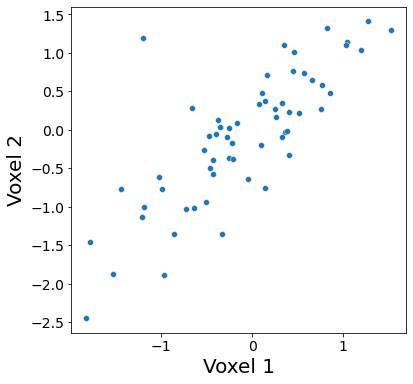

In [ ]:
# generate more multivariate normal data
np.random.seed(1)
sigmat = np.asarray((1,.9,.9,1))
sigmat.shape = (2,2)
mahdat = np.random.multivariate_normal([0, 0], sigmat, 60)

# create outlier
mahdat[0,:] = [-1.2,1.2]

# plot results
plt.figure(figsize=(6, 6))
fig = sns.scatterplot(x=mahdat[:,0],y=mahdat[:,1])
fig.set_xlabel('Voxel 1',fontsize=20)
fig.set_ylabel('Voxel 2',fontsize=20)
fig.tick_params(labelsize=14)

Euclidean distance assumes that the dimensions of the space are independent and equally weighted. The correlation between the voxels breaks that assumption. As a result, our outlier is not recognized as such by Euclidean distance - that is, it is not particularly far away from the other points, as seen in the heatmap below (looking at row/column 0).

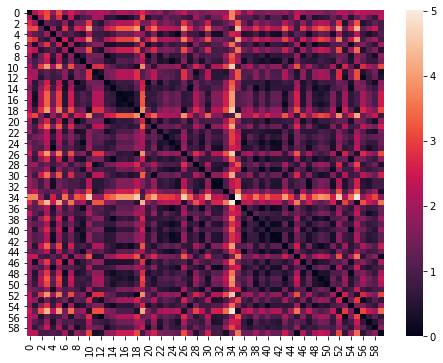

In [ ]:
plt.figure(figsize=(8, 6))
oedist = pdist(mahdat)
sns.heatmap(squareform(oedist))

Let's try this again with Mahalnobis distance. Although Mahalnobis distance can be computed with the same 'pdist' function from scipy that we have been using for other distances so far, it requires a second argument: the (matrix) inverse of the covariance between our two voxels. Since we simulated this data, we know the true population covariance matrix, and do not need to estimate it from the data. **Crucially** when doing this to real fMRI data, we do not use the raw covariance between voxels. Rather, we need to use the covariance of the voxelwise residuals of the GLM, so that we are only correcting for covariance due to noise, and not genuine covariance between voxels.

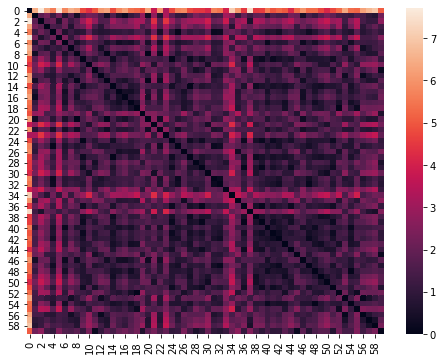

In [ ]:
# compute inverse of covariance matrix
iv = np.linalg.inv(sigmat)

# compute mahalanobis distance
omdist = pdist(mahdat,'mahalanobis',VI=iv)

# plot results
plt.figure(figsize=(8, 6))
sns.heatmap(squareform(omdist))

As the heatmap above shows, the outlier (condition 0) is now clearly revealed as an outlier by Mahalanobis distance. We can use an exploratory technique we'll see again in the last section - Multidimensional scaling - to visualize the corrected voxel space implied by multivariate noise normalized data.

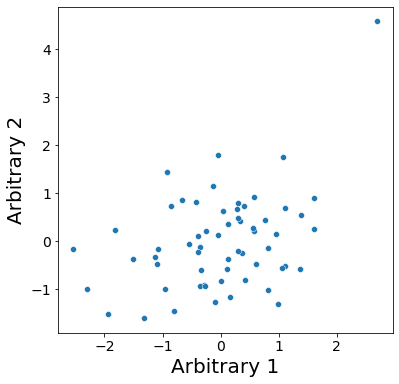

In [ ]:
# fit MDS
np.random.seed(1)
mds = MDS(dissimilarity="precomputed")
mds.fit(squareform(omdist))

# plot results
plt.figure(figsize=(6, 6))
fig = sns.scatterplot(x=mds.embedding_[:,0],y=mds.embedding_[:,1])
fig.set_xlabel('Arbitrary 1',fontsize=20)
fig.set_ylabel('Arbitrary 2',fontsize=20)
fig.tick_params(labelsize=14)

As we can see, our multivariate outlier is now a univariate outlier on both dimensions, and our two voxels are uncorrelated across conditions. (Note that the orientation of MDS results is arbitrary, so the graph show here is rotated with respect to the original voxels).

Multivariate noise normalization is useful in many realistic circumstances. However, one should be cautious about applying it in situations where the GLM you are running does not capture all of the psychologically meaningful/relevant features of the task. For example, if you are running a vision study in which you showed participants many different scenes, but only include GLM regressors that indicate whether the scene is indoor or outdoor, there is a lot of scene-related variability you are probably not capturing. This variability would be present in the GLM residuals, meaning that those residuals do not represent pure noise, but rather meaningful psychological covariance between voxels. As a result, multivariate noise normalization might distort, rather than rectify and enhance, the representational space you estimate.

### Cross-validated measures

Any of the measures we have discussed so far can be computed in a cross-validated fashion. That is, we could estimate patterns of brain activity for each condition from separate partitions of neural data. These partitions could be runs of your experiment, or some other sensible division - the important thing is that they need to be based on different data. Rather than computing the similarity between patterns estimated from the same data, we compute the similarity between patterns estimated from different data. As a bonus, part of this comparison is to compare the pattern from each condition to itself across partitions, giving us a nice estimate of pattern-wise reliability.

Why would we want to use cross-validated similarity measures instead of our regular similarity measures? No matter how good our experimental and imaging techniques are, there is always some noise involved in estimating activity patterns. This noise will biases the estimates of similarity between patterns. Consider the example below of two identical patterns with and without noise:

In [ ]:
# create two identical patterns
np.random.seed(1)
p1 = np.random.normal(size=(200))
p2 = p1.copy()
p12 = np.row_stack((p1,p2))

# distance between identical patterns with zero noise
pdist(p12)

array([0.])

In [ ]:
# add noise and re-correlate
np.random.seed(2)
p1n1 = p1 + np.random.normal(scale=1,size=(200))
p2n1 = p1 + np.random.normal(scale=1,size=(200))
p12n1 = np.row_stack((p1n1,p2n1))

pdist(p12n1)

array([21.29169931])

As the example above shows, adding noise to our activity pattern upwardly biases our estimate of the distances between them. Now let's consider a cross-validated version. In the cell below, we compute the cross-validated Euclidean distance repeatedly with different i.i.d. noise on each iteration.

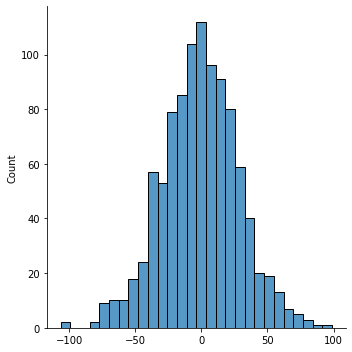

In [ ]:
np.random.seed(1)
nsplit = 1000 # number of simulations
cvd = np.zeros((nsplit,))
# simulate repeatedly
for i in range(nsplit):
    p1n1 = p1 + np.random.normal(scale=1,size=(200))
    p2n1 = p1 + np.random.normal(scale=1,size=(200))
    p1n2 = p1 + np.random.normal(scale=1,size=(200))
    p2n2 = p1 + np.random.normal(scale=1,size=(200))
    p1n1.shape = (1,200)
    p2n1.shape = (1,200)
    p1n2.shape = (200,1)
    p2n2.shape = (200,1)

    # compute cross-validated Euclidean distance
    cvd[i] = np.dot((p1n1 - p2n1),(p1n2 - p2n2))

# plot results across simulations
sns.displot(cvd)

As you can see, although there is considerable variance, the average value of the cross-validated Euclidean distance is ~0, unlike the un-cross-validated version. In other words, the cross-validation has eliminated the positive bias and restored a meaningful zero point. Importantly, the cross-validated Euclidean distance is not just the regular Euclidean distance between patterns from different partitions - hence why negative distances are possible. Composing an analogous cross-validated correlation coefficient can be difficult, so it is generally easier to use the Euclidean distance or Mahalnobis distance (cross-nobis) when using cross-validated measures.

Using cross-validated measures is most important when your analysis requires a meaningful zero point. They can also help deal with the issue described in the next section. However, this cost at a cost: there is a bias variance tradeoff in estimating pattern similarity, and eliminating the positivity bias comes at the cost of increasing the variance around your similarity estimates. This can be partially mitigated by using a larger number of partitions (e.g, a k=10-fold cross-validation would be preferable to split-half).

### Bayesian similarity measures

A very important element of fMRI design for RSA studies is minimizing the correlations between your condition regressors. Collinear regressors are bad enough in purely univariate analyses, since they inflate the variance of our parameter estimates. However, they are even worse when it comes to RSA, because highly collinear regressors can actually induce completely spurious pattern similarity.

Unfortunately, we sometimes have to deal with collinear regressors. Examples include naturalistic design, in which we cannot control the associations between features over time, and studies specifically focused on dynamics, in which conditions necessary proceed or follow one another with certain regularity.

Using cross-validated distance measures as described in the previous section can help to mitigate these issues, but only if the correlations between regressors differ over partitions. If they are consistent across the task - or if you are working in a low signal-to-noise situation - a potentially more promising alternative is using [Bayesian methods to estimate pattern similarity](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006299) directly from the preprocessed fMRI timecourses. We won't explore this method here since we aren't going to work directly with fMRI timecourses, but if you would like use this approach, it is conveniently implemented in the [BrainIAK](https://brainiak.org/) package.

# Comparing similarity matrices

## Correlation

Once you have computed similarity between your conditions, you will typically want to compare this similarity matrix to another similarity matrix. This is the heart of RSA, in that it allows us to compare one set of representations to representations in another participant, brain region, species, behavior, or computational model.

The simplest way to compare similarity matrices is to simply correlate them. We saw an example of this in the first section, reproduced below:

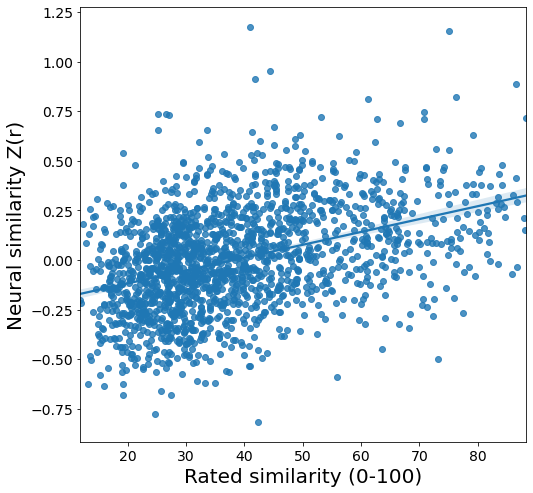

In [ ]:
# compute the correlation
np.corrcoef(nsim,rsim)[0,1]

# generate a scatterplot to go with it
plt.figure(figsize=(8, 8))
fig = sns.regplot(x=rsim,y=nsim)
fig.set_xlabel('Rated similarity (0-100)',fontsize=20)
fig.set_ylabel('Neural similarity Z(r)',fontsize=20)
fig.tick_params(labelsize=14)

There are a couple of important steps involved in correlating similarity matrices that this example does not show. The first is determining which part of the similarity matrices to correlate. If you use a function like scipy's pdist() to compute the similarity matrices, you will conveniently already have the part of the matrix you typically want to correlate in a vector form. However, this vector does not represent all of the elements in the corresponding matrix. Rather, it represents only the lower triangular (or equivalently, only the upper triangular) portion of the matrix. This is because most similarity matrices are symmetric across their diagonal, meaning that the upper and lower triangular components are redundant with one another. The diagonal is also typically uninformative (e.g., because the distance from something to itself is trivially zero). There are exceptions to these generalizations, such as the asymmetric measures we considered above, but they are quite rare in practice.

In the cell below, I illustrate how scipy's squareform function conveniently coverts between vectorized triangular similarity matrices, and full similarity matrices. Somewhat annoyingly, this function assumes that it is working with a distance matrix rather than a more generic (dis)similarity matrix. As a result, when inputting a square matrix to be vectorized, one must set its diagonal to zero first, if it is not already.

(60, 60)
(1770,)


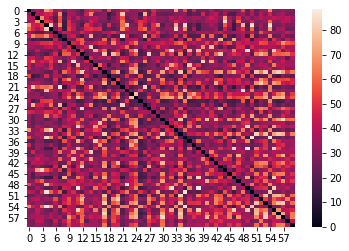

In [ ]:
# turn a vectorized similarity matrix into a full square matrix
sq = squareform(rsim)
print(sq.shape)
sns.heatmap(sq)

# reverse the process
vec = squareform(sq)
print(vec.shape)

# how to set the diagonal to zero (if necessary to get squareform to cooperate)
np.fill_diagonal(sq,0)

The other important consideration is what measure you're going to use to compare the similarity matrices. The choice of measure in this case is almost always a correlation-type measure, rather than a distance measure. We've already seen how to compute these various measures in the previous section, so for now let's just consider when to use the different types:

*   **Pearson correlation**: this is the probably most common/default choice used to compare similarity measures in the literature. It is most appropriate when your model makes precise numerical predictions about the similarity between your conditions, rather than ordinal or binary/categorical predictions.
*   **Spearman correlation**: the Spearman rank order correlation is another popular choice for comparing similarity matrices, and was recommended in the original paper promulgating RSA. It is most appropriate when your model makes ordinal, rather than metric or categorical predictions. It is also useful if your similarities are extremely skewed or feature serious outliers.
*   **Kendal correlation**: Kendells tau is another correlation based on rank orders. It is more appropriate than the Spearman correlation when your model makes binary/categorical predictions. 


## Regression

Comparing similarity matrices by correlating them makes a lot of sense when you only have two of them. In the example above, for instance, we only had neural similarity and similarity ratings to compare. However, in many cases you might want to model a given similarity matrix using a combination of multiple  predictors. Let's extend our example to consider this situation. 

In the cell below, we will read in more data about our 60 famous target people. These data consist of average ratings these targets on 13 dimensions dervied from psychological theories like the Big 5 personality trait and the stereotype content model.

In [ ]:
# read in data from URL
dims = pd.read_csv('http://scraplab.org/data/rsa_workshop/dimensions.csv')
dims.set_index('name',inplace=True)
print(dims.shape)
dims.head()

(60, 13)


,agency,agreeableness,attractiveness,competence,conscientiousness,dominance,experience,extraversion,intelligence,neuroticism,openness,trustworthiness,warmth
name,,,,,,,,,,,,,
Cesar Chavez,71.065217,47.511628,42.032787,71.313725,60.735849,75.018519,76.125000,66.000000,62.962963,53.916667,53.767857,46.018868,43.775510
Bill Nye,74.946429,80.461538,47.151515,81.222222,75.546875,49.647887,79.530612,71.362319,88.152542,38.736842,76.733333,79.377049,72.583333
Pablo Picasso,66.054545,56.370370,47.426471,76.954545,44.396825,56.071429,75.140000,26.092308,79.156250,66.561404,78.587302,58.967213,53.000000
William Shakespeare,70.689655,63.446429,50.478261,84.205882,69.107692,63.208333,82.903846,42.514706,82.892308,54.803279,70.687500,65.190476,58.349206
Abraham Lincoln,76.745763,78.879310,43.154930,89.617647,83.953846,83.097222,87.519231,50.000000,82.828125,26.466667,65.338462,84.093750,69.646154


In the cell below, we will extract out just the 5 columns corresponding to the Big 5, and then compute a Euclidean distance matrix between them. We will then correlate this matrix with our neural similarity matrix.

In [ ]:
# extract Big 5
big5 = dims.loc[:,['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']]

# compute Euclidean distances in Big 5 space and reverse code
bfd = -pdist(big5)

# correlate with neural similarity
np.corrcoef(nsim,bfd)[0,1]

0.20654398646456798

As we can see, the Big 5 traits are modestly correlated with neural similarity, with an r ~= .2. This is a fair bit less than the correlation with pairwise similarity ratings, but of course the Big 5 is a low-dimensionality representation, whereas the pairwise ratings had effectively arbitrarily high dimensionality.

The approach shown above is a valid way to test the Big 5's predictive power, but it makes a very strong assumption: that all five dimensions contribute evenly (or at least, in proportion with their intrinsic variance) to neural similarity. However, what we if wanted to consider any weighted combination of the Big 5 traits? Doing so would require a regression, rather than correlation. We demonstrate this method - which is sometimes referred to as "mixed" RSA" - in the cell below.

In [ ]:
# generate dissimilarity matrices for each of the Big 5 traits
bfdmat = np.zeros((1770,5))
for i in range(5):
    bfdmat[:,i] = -pdist(np.asarray(big5.iloc[:,i]).reshape((60,1)))
bfdmat = pd.DataFrame(bfdmat)
bfdmat.columns  = ['openness', 'conscientiousness', 'extraversion', 'agreeableness', 'neuroticism']
bfdmat = bfdmat.apply(zscore) # z-score to get std betas

# fit OLS linear regression
mod = sm.OLS(zscore(nsim), sm.add_constant(bfdmat))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     27.09
Date:                Mon, 05 Apr 2021   Prob (F-statistic):           1.78e-26
Time:                        15:31:02   Log-Likelihood:                -2446.1
No. Observations:                1770   AIC:                             4904.
Df Residuals:                    1764   BIC:                             4937.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.591e-17      0.02

As we can see in the regression output, the R<sup>2</sup> of the linear regression is .071, whereas the R<sup>2</sup> of the correlation version was only .2<sup>2</sup> = .04. This suggestions that our assumption that the Big 5 traits were equally weighted is probably not supported, since relaxing this assumption substantially improved the variance explained. Indeed, we even see that one of the traits has taken on a negative coefficient: targets with similar levels of neuroticism actually elicited different patterns of neural activity. However, I wouldn't read too much into this "effect", because neuroticism is quite collinear with agreeableness and conscientiousness in this sample, so the residual effect of neuroticism after accounting for these variables is not easy to interpret.

In this particular example, we have used ordinary least squares to fit our regression. However, if you are working strictly with distance matrices (and so all values are positive) then another alternative would be to use non-negative least squares. This form of regression is not implemented in the statsmodels package we used above, but it can be fit using an [optimizer from scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.nnls.html) or by using the positive=True argument in scikit-learn's linear regression. Note that this form of regression assumes not only that the observations are positive, but also that all regression coefficients are positive. As a result of the latter assumption, all coefficients that would become negative in OLS become 0s in NNLS. This can make significance testing of individual parameters tricky. More generally, you may not want to commit to this assumption on substantive grounds either, since genuinely negative RSA coefficients are possible. See the [research](https://thefinnlab.github.io/files/Finn_NeuroImage2020.pdf) of my colleague Emily Finn for intuitions about how to interpret data where neural similarity is not a direct linear function of proximity along a dimension.

## Significance testing

The regression output from statsmodels in the previous section included p-values and confidence intervals for the regression parameters in our mixed (i.e., multiple regression) RSA. Unfortunately, these values are likely to be overly optimistic, because the regression does not "know" that the variables it is modeling consist of similarity matrices. Similarity matrices imply dependencies that violate the assumption of independence baked into all linear models. As a result, the linear model ascribes more degrees of freedom than are actually present in the data, leading to unduly small standard errors and ultimately, p-values. To obtain appropriate p-values, we must adopt an alternative approach. There are two main strategies that have traditionally been used in the RSA literature to obtain valid p-values: the Mantel test, and the summary statistic approach to random effects.

### Mantel test

The Mantel test is a permutation test that respects the dependencies in similarity matrices. Specifically, rather than randomly permuting values within the vectorized similarity matrix, the Mantel test permutes the rows and columns of the full matrix prior to vectorization. Importantly, the rows and columns are permuted the same way on a given iteration. In other words, if I switch rows 15 and 44, I will also switch columns 15 and 44. In other other words, every permuted matrix you generate is still a valid similarity matrix, just with the conditions in a different order. This procedure recognizes that the conditions of your study, rather than the individual similarities, are the independent units of analysis under consideration. 

By permuting the order of one similarity matrix while holding the other fixed, and re-computing the correlation between their lower triangular components with every new permutation, we can create an empirical null distribution of correlations against which to compare the true correlation. If the true correlation is greater than 95% of the null correlations (or 97.5% in a 2-sided test) then the correlation is statistically significant. We illustrate this procedure with respect to neural similarity and pairwise similarity ratings in the cell below.

0.0


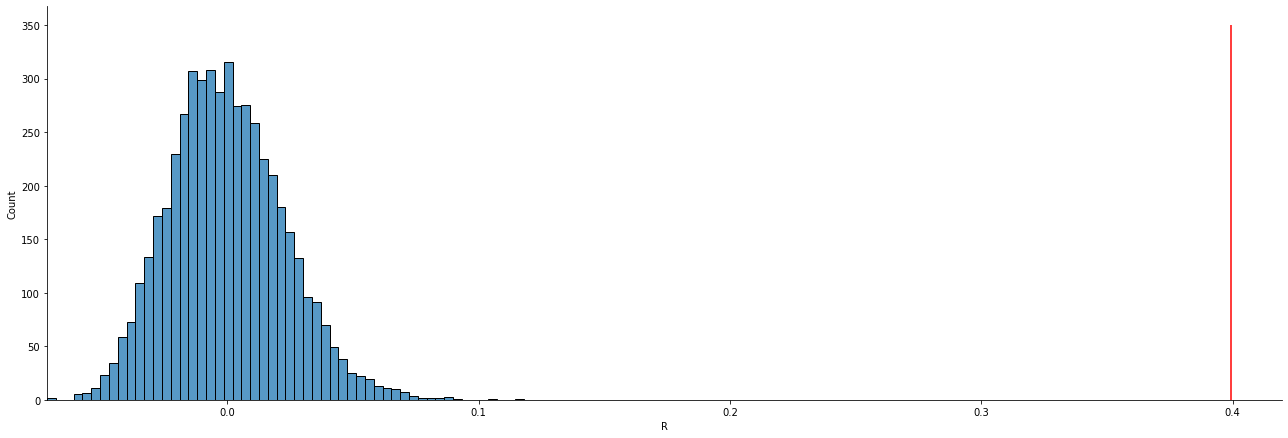

In [ ]:
np.random.seed(1)
nperm = 5000 # number of permutations
permr = np.zeros((nperm)) # preallocate results
for i in range(nperm):
    # permtuation vector - to be used for both rows and columns
    rsel = np.random.choice(60,60,replace=False)

    # permuting rating matrix
    sqrsim = squareform(rsim)
    prsim = sqrsim[rsel,:] # rows
    prsim = prsim[:,rsel] # columns
    prsim = squareform(prsim)

    # correlating with neural similarty matrix
    permr[i] = np.corrcoef(nsim,prsim)[0,1]

# compute p-value
teststat = np.corrcoef(nsim,rsim)[0,1]
print(np.mean(permr>teststat))

# plot null distribution and true test statistic
fig = sns.displot(permr,height=6,aspect=3)
fig.set_axis_labels("R")
fig.set(xlim=(np.min(permr), teststat+.02))
plt.vlines(teststat,0,350,color="red")

As we can see, the correlation between neural and rated similarity is clearly statistically significant - the null distribution is miles away from the actual test statistic. As an exercise, you could compare this result to a permutation test based on permuting the similarity vectors without respecting the rows and columns of the matrix. The corresponding null distribution should be narrower, indicating how this test is overly liberal.

Although we've written the logic of the test out here in detail for illustrative purposes, a convenient implementation can be found in [scikit-bio](http://scikit-bio.org/docs/0.1.3/generated/skbio.math.stats.distance.mantel.html) or in R's [vegan](https://cran.r-project.org/web/packages/vegan/index.html) package. Also, in this case we got a p-value of 0, but of course this is only because we are limited by the number of permutations we can run. If you need an exact p-value > 0, I would recommend looking into the methods described [here](https://www.sciencedirect.com/science/article/pii/S1053811916301902).

The Mantel test can also be generalized to multiple regression RSAs like the one we conducted in the previous section. The simplest way to do this is by permuting only the DV matrix rows/columns. However, there are multiple different schemes for permutation testing in multiple regression ([this](https://www.r-bloggers.com/2019/04/a-permutation-test-regression-example/) blog post is a place to start learning about them) although some of these approaches may not be compatible with the matrix permutation of the Mantel test.

### Summary statistic RFX

The Mantel test is most appropriate when you have a single similarity matrix to predict. However, in many fMRI experiments, we might have multiple similarity matrices - for example, one from each participant. In fact, this is precisely what the present "famous people" dataset consists of, with 29 different fMRI participants. One way to deal with this situation is to average these similarity matrices into one, and then perform the Mantel test on the correlation between this averaged neural matrix and whatever predictors you have in mind. Unfortunately, this approach is equivalent to a fixed effects analysis with respect to participants. In other words, the results assume that there are no individual differences between participants, or alternatively, the p-value only justifies inferences about this specific set of participants. The original RSA paper argued that the former was justifiable with respect to representations of visual objects. Whether that is true of vision or not, it is certainly false of high level social cognition in humans. Thus we need an alternative approach.

The approach that most RSA users have gravitated towards is the summary statistic approach to random effects. This approach is familiar to many fMRI users, because it is the same sort of approach that most studies take to group level univariate statistics. In short, a linear model is run separately within each participant, and then the parameters of these models are entered into a 2nd-level analysis, such as a t-test, across participants. An excellent comparison of this approach to other approaches to random effects can be found in [this](https://eshinjolly.com/2019/02/18/rep_measures/) blog post by my colleague Eshin Jolly. One alternative to the summary statistic approach would be to use full mixed effects modeling.

In the case of RSA, the summary statistic approach is relatively straightfoward. First, compute correlations (or regressions) between each participants' neural similarity matrix and the predictor matrices, then perform a t-test across those correlations to determine statistical significance. Generally speaking, it is also a good idea to subject correlation statistics (r/rho/tau) to Fisher's r-to-z transform (which is mathematically equivalent to the inverse hyperbolic tangent) prior to entering them into further analyses so that they better approximate linear, normally distribution values. We demonstrate this process in the cells below:

In [ ]:
# correlate pairwise similarity ratings with each participants' neural pattern similarity
ncors = ndat.corrwith(rsim)
ncors

V1     0.069531
V2     0.085366
V3     0.061922
V4     0.060948
V5     0.181288
V6     0.174299
V7     0.074879
V8     0.055207
V9     0.153380
V10    0.102651
V11    0.060328
V12    0.113166
V13   -0.010020
V14    0.160895
V15    0.058839
V16    0.145154
V17    0.112308
V18    0.153246
V19    0.118109
V20    0.137182
V21    0.107671
V22    0.085148
V23    0.183553
V24    0.121530
V25    0.031415
V26    0.149321
V27    0.085791
V28    0.066998
V29    0.100462
dtype: float64

As we can see, the correlations is positive for 28/29 participants. Significance testing is hardly necessary with such a strong effect.

In [ ]:
# Fisher transform correlations
zncors = np.arctanh(ncors)
zncors

V1     0.069643
V2     0.085574
V3     0.062002
V4     0.061023
V5     0.183314
V6     0.176097
V7     0.075019
V8     0.055263
V9     0.154600
V10    0.103013
V11    0.060401
V12    0.113653
V13   -0.010021
V14    0.162306
V15    0.058907
V16    0.146186
V17    0.112783
V18    0.154463
V19    0.118663
V20    0.138052
V21    0.108090
V22    0.085355
V23    0.185657
V24    0.122133
V25    0.031425
V26    0.150445
V27    0.086002
V28    0.067099
V29    0.100802
dtype: float64

Correlations values are nonlinear: the difference between r = .1 and .2 is much smaller than the difference between r = .8 and r = .9. Fisherizing transforms the distribution of correlation coefficients - bounded on the [-1, 1] interval - into a standard normal distribution. In the process, the values are linearized. However, this means that the transform has a relatively small effect on small correlations, so unless your data feature large correlations, the Fisher transform may not change things much.

In [ ]:
# perform one-sample t-test (vs. 0) on coefficients
ttest_1samp(zncors,0)

Ttest_1sampResult(statistic=11.624110185826085, pvalue=3.144405288296465e-12)

The result of the t-test is highly significant (p < 3.2 x 10<sup>-12</sup>), which isn't terribly surprising given the strength of this particular effect. T-tests can be implemented in a variety of different forms in Python. The cell above uses scipy's version; the cell below tests the same hypothesis in a regression formulation using statsmodels.

In [ ]:
# fit OLS linear regression
mod = sm.OLS(zncors, np.ones((29,1)))
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 05 Apr 2021   Prob (F-statistic):                nan
Time:                        15:31:04   Log-Likelihood:                 47.292
No. Observations:                  29   AIC:                            -92.58
Df Residuals:                      28   BIC:                            -91.22
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1041      0.009     11.624      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1657: RuntimeWarning: invalid value encountered in double_scalars
  return self.ess/self.df_model


In this case, the distribution of our participant-level coefficients is quite nicely behaved. However, if your data violate the assumptions of the linear model, you may want to use a non-parametric approach for more robustness. Bootstrapping is one such option:

[0.08647055 0.12158595]


array([0.03511541])

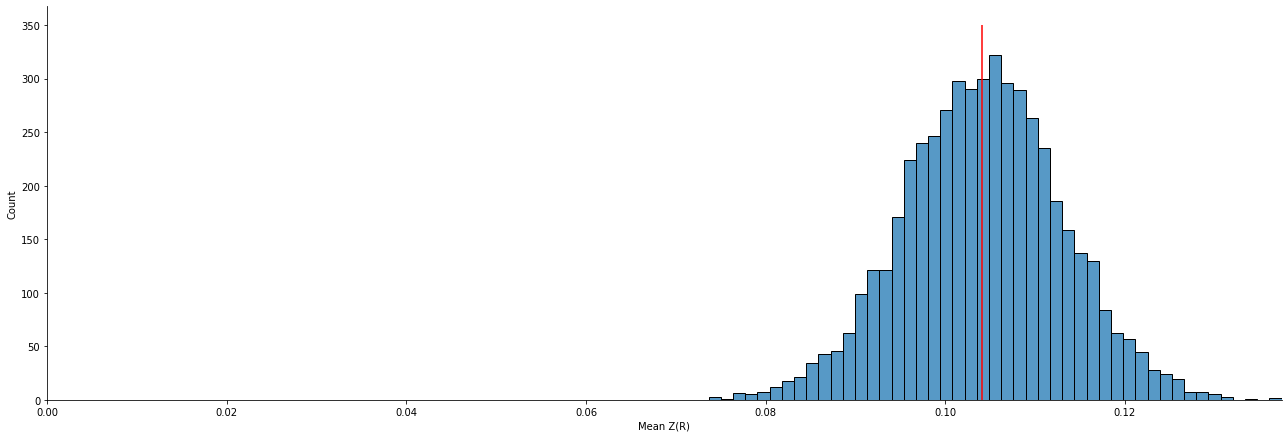

In [ ]:
np.random.seed(1)
nboot = 5000 # set bootstrap count
bmeans = np.zeros((nboot)) # preallocate output
for i in range(nboot):
    sel = np.random.choice(29,29,replace=True) # create resampling index
    bootdat = zncors[sel] # resample data
    bmeans[i] = np.mean(bootdat) # take mean of resampled data
print(np.quantile(bmeans,(.025,.975))) # get 95% CI (percentile bootstrap)

# visualize bootstrap distribution
fig = sns.displot(bmeans,height=6,aspect=3)
fig.set_axis_labels("Mean Z(R)")
fig.set(xlim=(0, np.max(bmeans)))
plt.vlines(np.mean(zncors),0,350,color="red")

np.diff(np.quantile(bmeans,(.025,.975)))

As we can see, the bootstrap distribution is far from zero, and the 95% CI does not overlap with zero. Thus this non-parametric approach corroborates the results we got through our parametric t-test.

Permutation testing would offer another nonparametric approach to significance testing. The version most equivalent to the bootstrap and t-test would be a sign-flipping procedure. However, you could also do a Mantel test at the participant level (in which each participants' similarity matrix was randomized in the same way on a given iteration). A good nonparametric approach might be to combine this matrix randomization with bootstrapping at the participant level. We illustrate this in the cell below:

0.0


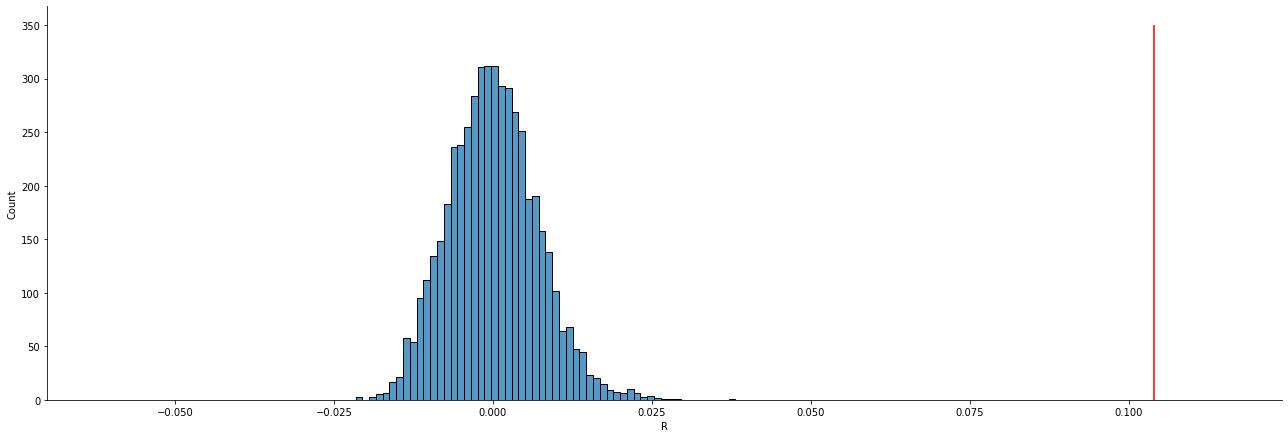

In [ ]:
np.random.seed(1)

# permutation procedure
nperm = 1000 # number of permutations
permr = np.zeros((nperm,29)) # preallocate results
for i in range(nperm):
    # permtuation vector - to be used for both rows and columns
    rsel = np.random.choice(60,60,replace=False)

    # permuting rating matrix
    sqrsim = squareform(rsim)
    prsim = sqrsim[rsel,:] # rows
    prsim = prsim[:,rsel] # columns
    prsim = squareform(prsim)

    # correlating with neural similarty matrix
    permr[i,:] = ndat.corrwith(pd.Series(prsim))

# bootstrapping
nboot = 5000 # set bootstrap count
bmeans = np.zeros((nboot)) # preallocate output
for i in range(nboot):
    bsel = np.random.choice(29,29,replace=True) # which participants to resample
    psel = np.random.choice(nperm,1,replace=False) # which permutation to use
    bootdat = permr[psel,bsel] # resample data
    bmeans[i] = np.mean(bootdat) # take mean of resampled data
print(np.mean(bmeans>np.mean(zncors))) # p-value (one-sided)

# plot null distribution and true test statistic
fig = sns.displot(bmeans,height=6,aspect=3)
fig.set_axis_labels("R")
fig.set(xlim=(np.min(permr), np.mean(zncors)+.02))
plt.vlines(np.mean(zncors),0,350,color="red")

Note that, because of the permutation involved in the first step, we ultimately get an empirical null distribution rather than a distribution around the population parameter with this approach. Much like full mixed effects modeling, this multi-level resampling technique can either increase or decrease p-values relative to the summary statistic approach, depending on the circumstances. On one hand, this approach capitalizes on item-level information within each participant that is unavailable to the summary statistic approach, which will tend to decrease p-values. On the other hand, this item-level variability can also increase the width of the bootstrap distribution if the permutation distribution is very wide. Holding p-values constant, using the multi-level resampling approach (or mixed effects models) better licenses generalization to population of conditions in comparison to the summary statistic approach, though this is more important when your sample of conditions is relatively small compared to the population.

## Effect sizes and cross-validation

### Basic effect sizes

The previous section focused on inference: how can we tell whether an effect is significant or not? However, it is also important to consider the size of the effect. There are two basic effect sizes for RSA: correlations, and Cohen's d.

The correlation effect size is simply the correlation between your model similarity matrix and your neural (or other DV) similarity matrix. If you have multiple dependent variables (e.g., multiple participants, as in the previous section) you can average correlations across them. It is best to use Fisher's z transform before the averaging, and then reverse the transform after averaging:

In [ ]:
# fixed effects correlation
np.corrcoef(nsim,rsim)[0,1]

0.3994679727516274

In [ ]:
# mean participant correlation
np.tanh(np.mean(np.arctanh(ndat.corrwith(rsim))))

0.10369320509115904

You may notice in the example above that the effect size from the fixed effects analysis is larger than the mean correlation from the random effects version. This is almost always true, though the size of the difference between them will depend on the number of participants and the inter-participant reliability of the neural similarity matrices. By averaging together participants, we are increase the reliability of the cross-participant composite, thereby reducing the [correlation attenuation](https://en.wikipedia.org/wiki/Correction_for_attenuation). Thus it can be helpful to report the fixed effects correlation, even if your inferential tests are conducted using random effects.

Rather than (just) reporting the average of the highly attenuated individual correlations, using Cohen's d can be a good alternative approach. This measure standardizes the mean by its standard deviation, which helps offset the arguably misleadingly small correlations that tend to result at the individual level of RSAs. There are many different formula for computing Cohen's d, but one that is quite general is to take whatever t-statistic you have (e.g., from a t-test or regression) and divide it by the square root of n. 

In [ ]:
ttest_1samp(zncors,0).statistic/np.sqrt(29)

2.158543071964288

As we can see, in this instance the Cohen's d > 2, which qualifies as a huge effect size by most rules-of-thumb. 

Both correlation and Cohen's d effect sizes can be generalized to the multiple regression form of RSA as well. In this context, correlation coefficients are replaced by standardized betas, and Cohen's d values for each predictor can be computed by running t-tests across the corresponding unstandardized regression coefficients (and then dividing the t-stats by sqrt(n)).

### Cross-validation

The basic effect sizes we consider in the previous sections are all "within-sample". Depending on the complexity of your model, these effects may be overly optimistic due to overfitting. Cross-validation allows us to compute the generalization performance of our models: an estimate of how well they would perform in new data. 

When setting up a cross-validated analysis, it is important to consider what form(s) of newness you want to challenge your model with. For example, you could just cross-valiate with respect to participants but not conditions or vice-versa. In the cell below I illustrate an example of how to cross-validate to both at the same time.

In [ ]:
# loop through different partitions
np.random.seed(1)
npart = 1000
cvr2 = np.zeros((npart))
for p in range(npart):

    # generate random split-half of conditions
    csel1 = np.random.choice(60,30,False)
    csel2 = [c for c in range(60) if c not in csel1]

    # use indexes to split predictors (Big 5)
    bfdmat1 = np.zeros((435,5))
    bfdmat2 = np.zeros((435,5))
    for i in range(5):
        bfdmat1[:,i] = -pdist(np.asarray(big5.iloc[csel1,i]).reshape((30,1)))
        bfdmat2[:,i] = -pdist(np.asarray(big5.iloc[csel2,i]).reshape((30,1)))

    # use indexes to split neural data
    ndat1 = np.zeros((435,29))
    ndat2 = np.zeros((435,29))
    for i in range(29):
        ndat1[:,i] = squareform(squareform(zndat[:,i])[:,csel1][csel1,:])
        ndat2[:,i] = squareform(squareform(zndat[:,i])[:,csel2][csel2,:])

    # random split half of participants:
    psel1 = np.random.choice(29,15,False)
    psel2 = [c for c in range(29) if c not in psel1]
    dv1 = ndat1[:,psel1].mean(axis=1)
    dv2 = ndat2[:,psel2].mean(axis=1)

    # fit models
    lm1 = LinearRegression()
    lm2 = LinearRegression()
    lm1.fit(bfdmat1,dv1)
    lm2.fit(bfdmat2,dv2)

    # evaluate models
    cvr2[p] = np.mean([lm1.score(bfdmat2,dv2),lm2.score(bfdmat1,dv1)])
np.mean(cvr2) # print mean R2 across 1000 partitions

0.01692947842287466

In [ ]:
# in-sample R2 for comparison
lm = LinearRegression()
lm.fit(bfdmat,nsim)
lm.score(bfdmat,nsim)

0.07130071434592178

In this particular case, we can see that the cross-validated performance (R<sup>2</sup>  = .017) is considerably less than the in-sample performance (R<sup>2</sup>  = .071), indicating that there is a fair bit of overfitting. As a result, we should be cautious about generalizations to new famous people/participants. Comparing these results to cross-validation across only participants, or across only famous people, could help determine which of these is driving the overfitting.

If you are interested in more extensive overview of the uses of cross-validation in psych/neuro, I have a separate tutorial focused on that issue that you can access [here](https://github.com/markallenthornton/cross_validation_workshop).

#### Noise ceiling

Cross-validation can also be used to help better contextualize our basic effect sizes. Given that there is noise (measurement error) in our data, we know that not even a "perfect" model will perform perfectly. That is, even if we could compute exactly how the brain represents other people, we could not get R<sup>2</sup>  = 1 in these data. However, we can use the data themselves to calculate a noise ceiling - an estimate of the hypothetical maximal performance of any model, given the noise in the data. My friend Beau Sievers has an excellent blog post on noise ceilings you can check out [here](https://github.com/beausievers/noise_ceiling/blob/master/noise_ceiling_tutorial.ipynb). The basic idea is to use the average of all participants but one as a proxy for the perfect model, and correlate this average the neural similarity matrix of the left our participant (leaving out each in turn). This can then be compared to the performance of whatever substantive model you're interested in.

In [ ]:
nceils = np.zeros((29))
for i in range(29):
    loo = np.mean(np.delete(zndat,i,1),1) # average all but one
    nceils[i] = np.corrcoef(loo,zndat[:,i],rowvar=False)[0,1] # correlate with left out participant
np.mean(nceils) # average noise ceiling

0.12958456139140254

In this case, we can see that the noise ceiling for any model is R = .1295. This can be compared to the performance of other theories. For example, in the basic effect sizes sections, we saw that our pairwise similarity ratings achieve an average R = .1037. Dividing this by the noise ceiling tells us that the pairwise similarity ratings achieve ~80% of the performance that we could possibly hope for, given the noise in the neural data.

#### Model selection

Cross-validated model performance is also an excellent basis for selecting among different possible models in RSA. Unlike in-sample performance statistics - like R<sup>2</sup> - cross-validated performance measures do not bias us towards more complex models. Thus in the cell below, we can fairly compare the performance of all 13 trait dimensions we had rated, to just the Big 5 (above).

In [ ]:
# loop through different partitions
np.random.seed(1)
npart = 1000
cvr2 = np.zeros((npart))
for p in range(npart):

    # generate random split-half of conditions
    csel1 = np.random.choice(60,30,False)
    csel2 = [c for c in range(60) if c not in csel1]

    # use indexes to split predictors (all traits)
    dims1 = np.zeros((435,13))
    dims2 = np.zeros((435,13))
    for i in range(13):
        dims1[:,i] = -pdist(np.asarray(dims.iloc[csel1,i]).reshape((30,1)))
        dims2[:,i] = -pdist(np.asarray(dims.iloc[csel2,i]).reshape((30,1)))

    # use indexes to split neural data
    ndat1 = np.zeros((435,29))
    ndat2 = np.zeros((435,29))
    for i in range(29):
        ndat1[:,i] = squareform(squareform(zndat[:,i])[:,csel1][csel1,:])
        ndat2[:,i] = squareform(squareform(zndat[:,i])[:,csel2][csel2,:])

    # random split half of participants:
    psel1 = np.random.choice(29,15,False)
    psel2 = [c for c in range(29) if c not in psel1]
    dv1 = ndat1[:,psel1].mean(axis=1)
    dv2 = ndat2[:,psel2].mean(axis=1)

    # fit models
    lm1 = LinearRegression()
    lm2 = LinearRegression()
    lm1.fit(dims1,dv1)
    lm2.fit(dims2,dv2)

    # evaluate models
    cvr2[p] = np.mean([lm1.score(dims2,dv2),lm2.score(dims1,dv1)])
np.mean(cvr2) # print mean R2 across 1000 partitions

0.018611609485673378

As we can see, the full set of 13 dimensions achieves an (R<sup>2</sup>  = .0186), a small improvement from the performance of the Big 5 (R<sup>2</sup>  = .0168), suggesting that the Big 5 is a good, but perhaps not totally complete, characterization of the trait space people apply to organize their representations of other people.

This sort of model comparison process can also be used to select which combination of candidate dimensions to incorporate into a model. However, bear in mind that the performance of the selected model will likely be inflated by procedural overfitting, so a third data partition (a hold-out set) would be need to make an unbiased estimate of the performance of that final selected model.

# Visualization and fMRI considerations

## Visualizations

Visualizing similarity data can help us identify problems with our data, violations of model assumptions, or structure that might not be explained by our models. Fortunately, there are many visualization that can help us explore similarity data.

### Heatmaps

The most common visualization used to explore similarity data is a heatmap. Heatmaps are exhaustive veridical representations of the similarity matrix, which makes them a good choice to include among other visualization which might be easier to interpret but distort the data somewhat.

We've seen several examples of heatmaps already in this workshop, but here we will demonstrate one important trick that can it much easier to identify the structure in these maps. That trick relates to how to sort the heatmap. Unsorted heatmaps contain all of the same information as sorted heatmaps, but are much harder to interpret. In the cell below, we plot an unsorted heatmap of our famous people, visualizing Big 5 proximities (reverse-coded distances).

Text(0.5, 1.0, 'Big 5 distances')

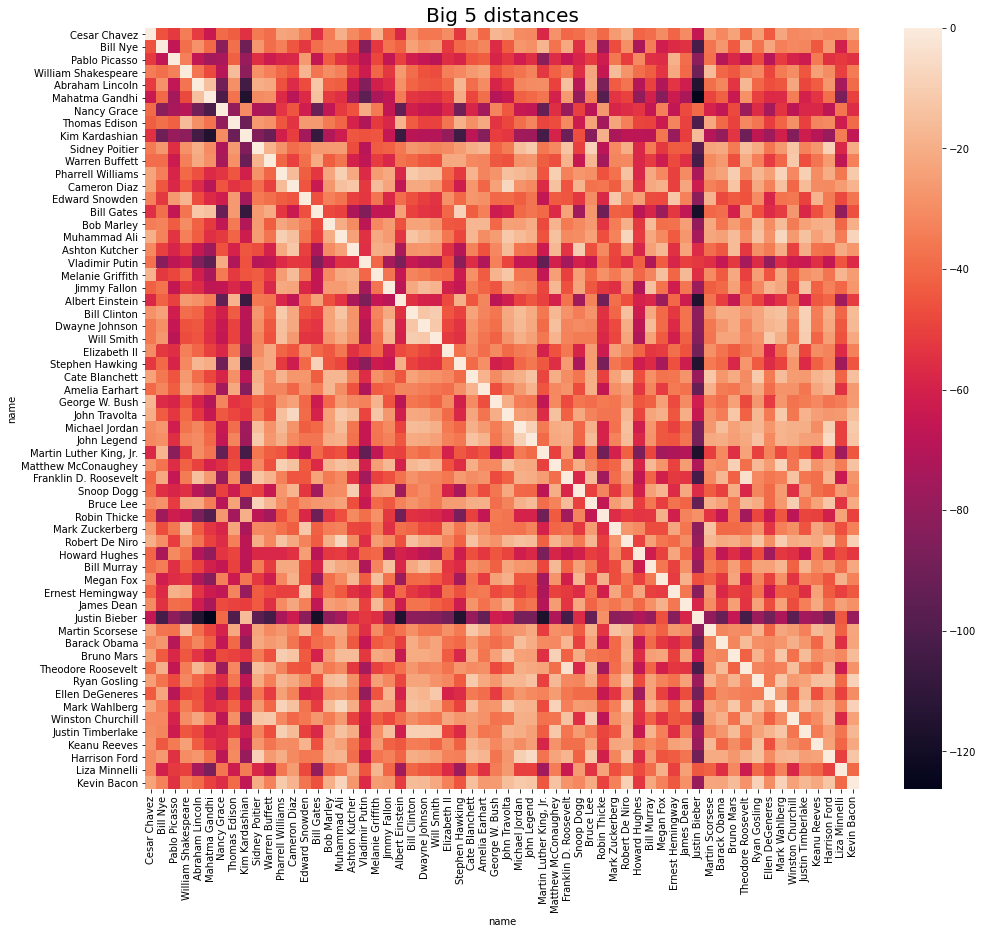

In [ ]:
bfsq = pd.DataFrame(squareform(bfd),index=dims.index,columns=dims.index)
plt.figure(figsize=(16, 14))
ax = plt.axes()
sns.heatmap(bfsq,ax=ax)
ax.set_title('Big 5 distances', fontsize=20)

We can see that there is probably some structure her, but it's hard to see what it is. Now let's use agglomerative clustering to sort the heatmap! The sort of the heatmap - together with the dendrogram - make it much easier to observe the structure in the similarity matrix.

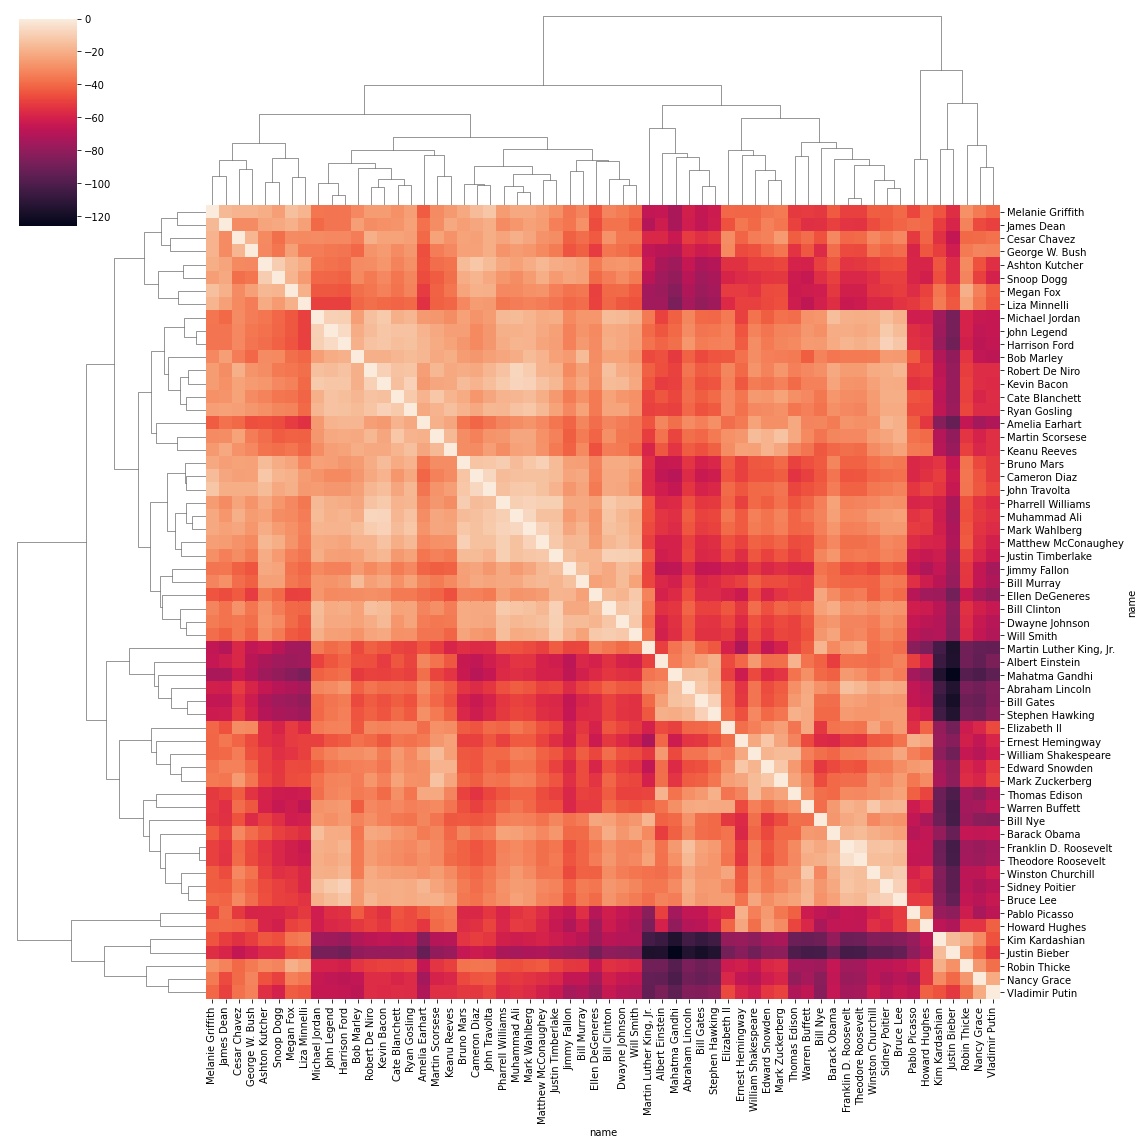

In [ ]:
sns.clustermap(bfsq,figsize=(16, 16))

### Manifolds

Another popular way to visualize similarity data is through manifolds. Manifold learning is a form of unsupervised machine learning in which the algorithm attempts to learning a low-dimensional metric (rather than categorical) representation of the data. There are many manifold learning algorithms out there, but two useful methods to learn are multidimensional scaling and UMAP.

#### Multidimensional scaling

Multidimensional scaling (MDS) is a form of manifold learning that has been popular in psychology for decades. The circumplex model of affect, for instance, owes its inception in large part to MDS. This algorithm takes in a distance matrix, and attempts to arrange points within an N-dimensional manifold (where N is chosen by the user, but usually 2d or 3d) such that they maximally reproduce the input distances.

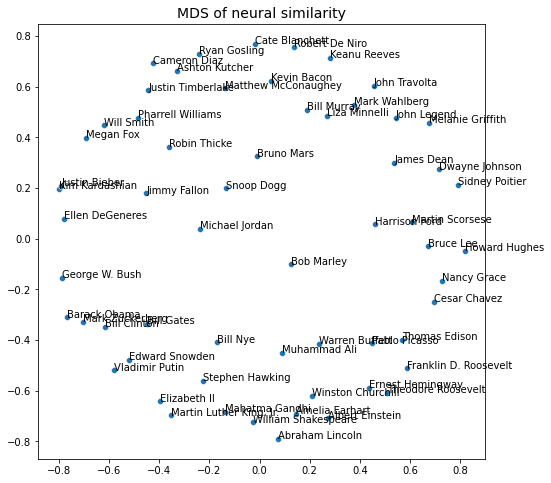

In [ ]:
# fit MDS
mds = manifold.MDS(n_components=2,metric=True,dissimilarity='precomputed').fit(1-squareform(nsim))

# Create figure
np.random.seed(1)
plt.figure(figsize=(8, 8))
fig = sns.scatterplot(x=mds.embedding_[:, 0], y=mds.embedding_[:, 1])
fig.set_title("MDS of neural similarity", fontsize=14)
for i, txt in enumerate(dims.index):
    fig.annotate(txt, (mds.embedding_[i, 0], mds.embedding_[i, 1]))

In the plot above, famous people who elicited more similar activity patterns are placed closer together. Note that MDS (and other manifold learning algorithms) have to make compromises when projecting a high-dimensional space down into a lower-dimensional space. Maps of the Earth are a great example of this: it's impossible to make a 2d map of the whole surface without distorting either angle or area. This is why one of the reasons it is useful to complement manifold maps with heatmaps.

To see how distorted our MDS results are, we can examine the "stress" statistic. This measures the disparities between distances in the 2d MDS space, and the original distances. The raw stress provided my scikit-learn is the sum of squared disparities, but is often reported as the root mean in other implementations. Stress cannot be evaluated in absolute terms, because it is dependent on (among other things) the number of points in our MDS. However, relative stress can be used to help identify the best fitting low dimensional representation. Increasing dimensionality, or using non-metric (ordinal) MDS, both tend to improve fit, as we show below:

In [ ]:
# original stress
mds.stress_

217.7665826153268

In [ ]:
# 3d stress
mds3 = manifold.MDS(n_components=3,metric=True,dissimilarity='precomputed').fit(1-squareform(nsim))
mds3.stress_

129.02961111034458

In [ ]:
# non-metric stress
mds_nm = manifold.MDS(n_components=2,metric=False,dissimilarity='precomputed').fit(1-squareform(nsim))
mds_nm.stress_

75.1678370387465

In [ ]:
# 3d non-metric stress
mds_nm3 = manifold.MDS(n_components=3,metric=False,dissimilarity='precomputed').fit(1-squareform(nsim))
mds_nm3.stress_

50.48576174578967

Biplots (and manifold embedding visualizations in general) can be enhanced by the addition of biplots. Biplots are arrows placed onto an embedding to illustrate how substantive variables correlate with the axes of that embedding.

Text(0.6209604874536089, -0.30614839047994313, 'Competence')

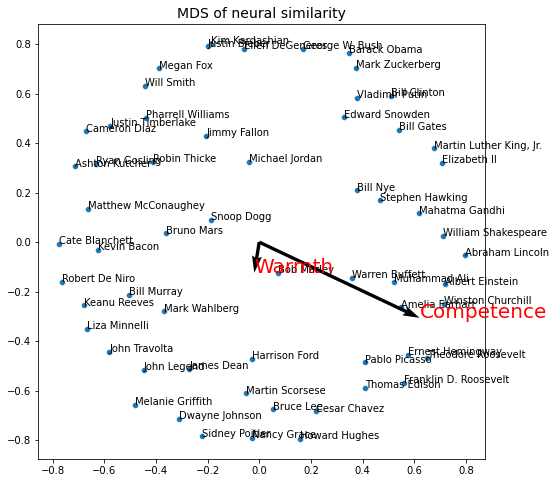

In [ ]:
# fit MDS
mds = manifold.MDS(n_components=2,metric=True,dissimilarity='precomputed').fit(1-squareform(nsim))

# correlate stereotype content dimensions with embedding axes
scm = dims.loc[:,['warmth', 'competence']]
bp = np.corrcoef(scm, mds.embedding_,rowvar=False)[0:2,2:4]

# Create figure
np.random.seed(1)
plt.figure(figsize=(8, 8))
fig = sns.scatterplot(x=mds.embedding_[:, 0], y=mds.embedding_[:, 1])
fig.set_title("MDS of neural similarity", fontsize=14)
fig.quiver((0,0), (0,0), bp[:,0], bp[:,1], angles="xy",scale=1,scale_units='xy')
for i, txt in enumerate(dims.index):
    fig.annotate(txt, (mds.embedding_[i, 0], mds.embedding_[i, 1]))
fig.annotate("Warmth",(bp[0,:]),color="red",fontsize=20)
fig.annotate("Competence",(bp[1,:]),color="red",fontsize=20)

Biplots help to add meaning to the axes of an MDS, which are otherwise arbitrary. Moreover, the length of each arrow indicates the degree to which it is correlated with each axis.

Another useful application of UMAP is visualize how close *models* are to each other, rather than how close the conditions of your experiment are to each other. The figure below illustrates this with five different measures of similarity between famous people:

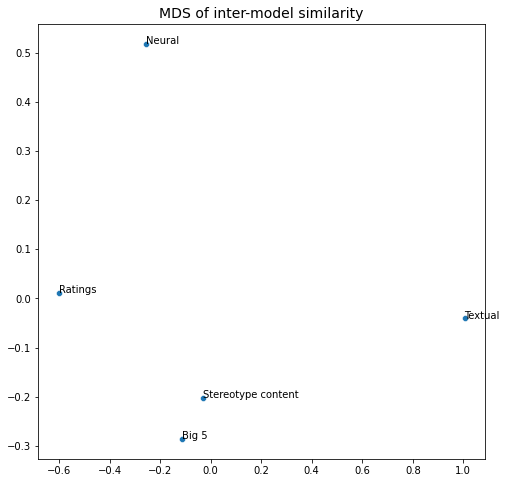

In [ ]:
# stereotype content model
scmd = -pdist(scm)

# combine models into dataframe
multimodel = pd.DataFrame({"Neural":nsim, "Ratings":rsim, "Textual": holdat.text, "Big 5": bfd, "Stereotype content": scmd})

# compute 2nd-level (dis)similarity matrix (between models)
rdm2 = 1-np.corrcoef(multimodel,rowvar=False)

# fit MDS
mds = manifold.MDS(n_components=2,dissimilarity='precomputed').fit(rdm2)

# Create figure
np.random.seed(1)
plt.figure(figsize=(8, 8))
fig = sns.scatterplot(x=mds.embedding_[:, 0], y=mds.embedding_[:, 1])
fig.set_title("MDS of inter-model similarity", fontsize=14)
for i, txt in enumerate(multimodel.columns):
    fig.annotate(txt, (mds.embedding_[i, 0], mds.embedding_[i, 1]))

This helps us see that the two psychological theories - the stereotype content model and the Big 5 - are more similar to each other than to pairwise similarity ratings, neural similarity, or textual similarity (estimated from Wikipedia biographies of the famous people).

#### UMAP

[UMAP](https://umap-learn.readthedocs.io/en/latest/index.html) - or uniform manifold approximation and projection - is a far more modern manifold learning algorithm than MDS. It is popular in certain data-intensive fields, but has only started to make an appearance in psychology and cognitive neuroscience. UMAP attempts to preserve not only the global structure in data (e.g., the main axes of variance, which PCA extracts) but also the local structure (e.g., which points are the nearest neighbors of which others). As a result, UMAP can also capture nonlinearities in the data that PCA and similar dimensionality reduction methods would not appropriately recognize. In the plot below, we use UMAP to create a 2d map of the neural similarity data.

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


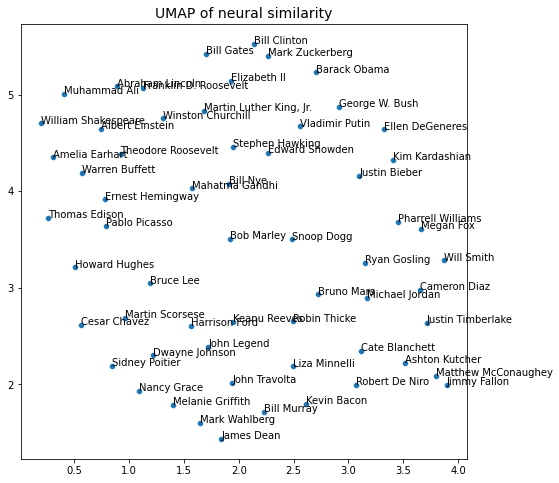

In [ ]:
# fit MDS
um = umap.UMAP(metric='precomputed').fit(np.max(nsim)-squareform(nsim))

# Create figure
np.random.seed(1)
plt.figure(figsize=(8, 8))
fig = sns.scatterplot(x=um.embedding_[:, 0], y=um.embedding_[:, 1])
fig.set_title("UMAP of neural similarity", fontsize=14)
for i, txt in enumerate(dims.index):
    fig.annotate(txt, (um.embedding_[i, 0], um.embedding_[i, 1]))

Generally speaking, UMAP will tend to enhance the "clusteriness" of the data, relative to algorithms like PCA and MDS. We can see this in a striking way in the graph below, which applies UMAP to the pairwise similarity ratings instead of the neural similarity.

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


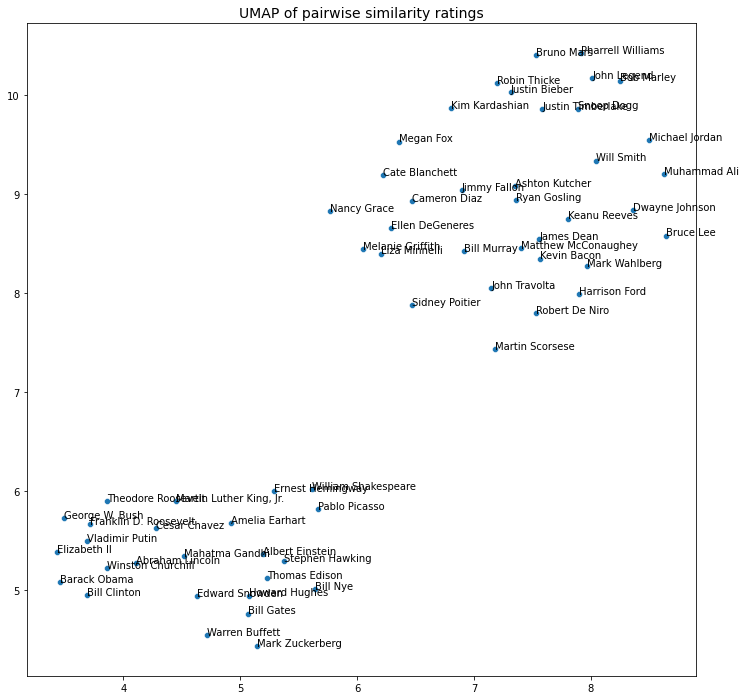

In [ ]:
# fit MDS
um = umap.UMAP(metric='precomputed').fit(100-squareform(rsim))

# Create figure
np.random.seed(1)
plt.figure(figsize=(12, 12))
fig = sns.scatterplot(x=um.embedding_[:, 0], y=um.embedding_[:, 1])
fig.set_title("UMAP of pairwise similarity ratings", fontsize=14)
for i, txt in enumerate(dims.index):
    fig.annotate(txt, (um.embedding_[i, 0], um.embedding_[i, 1]))

As you can see, UMAP has separated our data into two distinct clusters, one composed primarily of people in the entertainment industry, and the other composed primarily of political and scientific figures. Although this separation does reflect a feature of the data, it also accentuates this difference beyond the raw similarities. Thus UMAP can be very helpful for seeing the structure in data, but should not be taken as a veridical representation of similarity.

UMAP has a number of parameters that affect what sort of structure it reveals in the data. The most important for most purposes is the number of nearest neighbors it considers. Increasing the number of neighbors will tend to shift the balance of the algorithm from local to global structure. Observe below how this changes the results:



/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


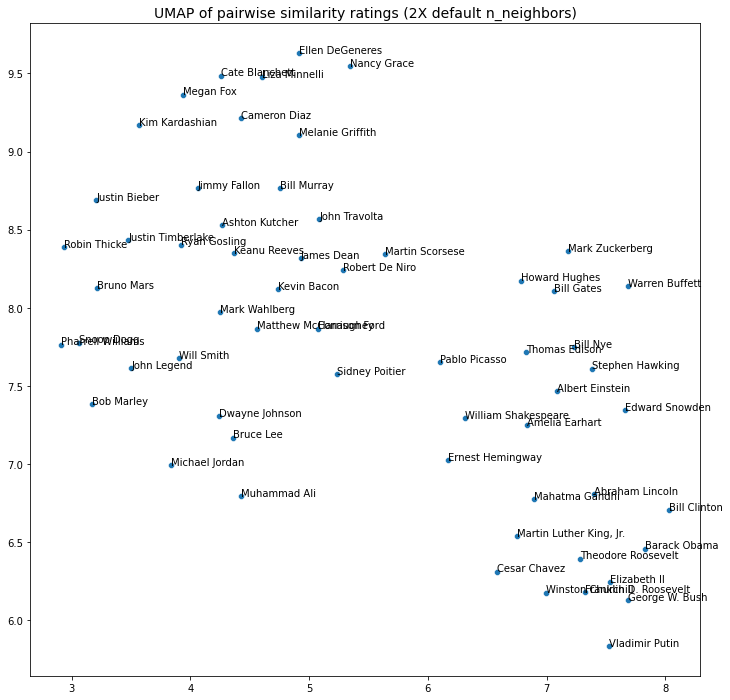

In [ ]:
# fit MDS
um = umap.UMAP(n_neighbors=30,metric='precomputed').fit(100-squareform(rsim))

# Create figure
np.random.seed(1)
plt.figure(figsize=(12, 12))
fig = sns.scatterplot(x=um.embedding_[:, 0], y=um.embedding_[:, 1])
fig.set_title("UMAP of pairwise similarity ratings (2X default n_neighbors)", fontsize=14)
for i, txt in enumerate(dims.index):
    fig.annotate(txt, (um.embedding_[i, 0], um.embedding_[i, 1]))

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


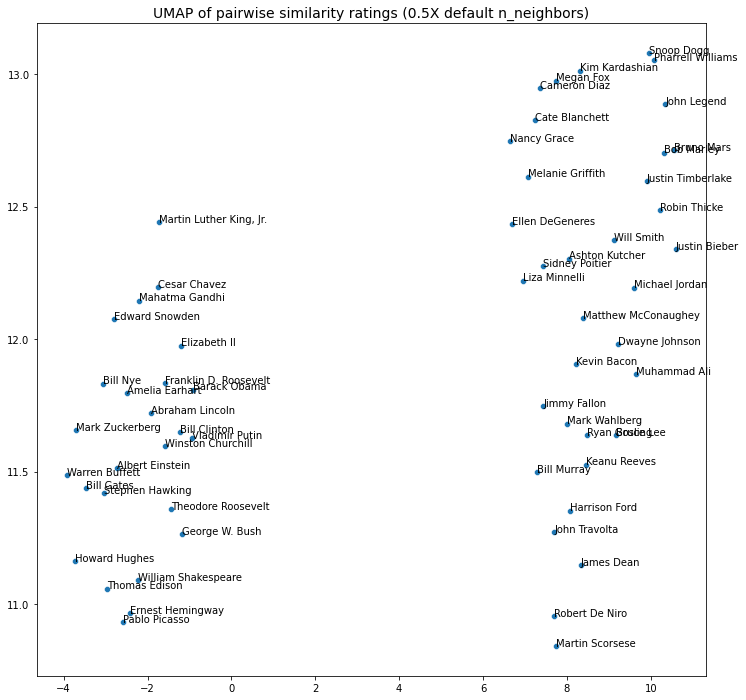

In [ ]:
# fit MDS
um = umap.UMAP(n_neighbors=8,metric='precomputed').fit(100-squareform(rsim))

# Create figure
np.random.seed(1)
plt.figure(figsize=(12, 12))
fig = sns.scatterplot(x=um.embedding_[:, 0], y=um.embedding_[:, 1])
fig.set_title("UMAP of pairwise similarity ratings (0.5X default n_neighbors)", fontsize=14)
for i, txt in enumerate(dims.index):
    fig.annotate(txt, (um.embedding_[i, 0], um.embedding_[i, 1]))

If you're interested in understanding UMAP more deeply, [this](https://pair-code.github.io/understanding-umap/) is an excellent post that details its parameters and allows you to interactively examine how they change the results.

## RSA and fMRI

Although RSA can in principle be applied to a wide variety of different data types, its most popular application remains modeling fMRI data. In this section we consider some of the design and preprocessing considerations relevant for generating RSA-ready fMRI data.

### Designing RSA studies

Many of the general principles of fMRI study design also apply to RSA. We will limit the discussion here to topics which are particularly or uniquely relevant to RSA. One of the most important considerations in designing an fMRI study is determining the tradeoff between the number of conditions, trials per condition, and participants, assuming that one has a fixed amount of scan time available (e.g., limited by budget).

#### Condition number

By "condition", we refer here to whatever unit is determining the size of your similarity matrix. In most RSA-fMRI studies, stimuli from the same condition are presented repeatedly over the course of the fMRI session and the corresponding neural responses are averaged via the GLM to produce relatively stable activity patterns associated with each condition (which are then entered into RSA). 

It is possible to conduct RSA on a trialwise basis, yielding a similarity matrix in which each row/columns is a trial rather than an average of multiple trials. This approach tends to yield much lower SNR than averaging multiple trials, so it should only be employed in cases where the intrinsic SNR is relatively high (e.g., relatively simple, low-level stimuli, with long trials). This approach also tends to produce high correlations between regressors, especially if used in a fast event related design. This can complicate analysis, as we describe in the similarity measures section above. Similarity measures such as Bayesian RSA should be used to help mitigate the negative consequences of such correlations, and ideally the hypotheses being tested should also be orthogonal to any spurious pattern similarity induced by trial regressor collinearity.

In the more common situation in which each condition features multiple trials, how many conditions should you target? There are two main considerations that can help make this decision, one statistical, and one substantive. The statistical issue is that the size of a similarity matrix will grow as the square of the number of conditions. So, for example, a 10 condition study will produce a similarity matrix with 100 total elements, whereas a 20 condition study will produce a similarity matrix with 400 total elements. Taking advantage of this scaling can help better disambiguate hypotheses and differentiate models. Additionally, thinking about the size of the lower triangle of the similarity matrix can help set a floor on the number of conditions. Given that correlations tend to [stabilize around 250 observations](https://www.sciencedirect.com/science/article/abs/pii/S0092656613000858), this calls for ~23 conditions.

The substantive concern that should guide your condition number is the "size" of the psychological/stimulus space in question. The size of such a space could be quantified in many different ways, of course, but some spaces are definitely larger than others. For example, English dictionaries contain ~300 nouns corresponding to mental states (emotions and cognitive states) whereas they contain thousands of action verbs. Thus one might argue that far more action verbs than mental state nouns are required to sample these spaces with the same density. The dimensionality of a space is also a pertinent concern. You likely want your conditions to sample representatively from each region of a space, which will require more conditions for a high dimensional space. At the other end of the spectrum, some psychological spaces (naturally occurring or engineered in an experiment) may be quite small, to the extent that you might even be to sample them exhaustively.

#### Trial number

How many trials should you present for each condition in your study? The simple answer is any many as possible, but of course there are tradeoffs involved:


*   **Trial SNR**: the more signal each trial contributes, the fewer you need. So, for example, you will need fewer 10s trials than 2s trials, all else equal. What matters is the length of the portion of the trial that you model with your condition regressor, so other parts of the trial don't really count in this regard. Other factors, such as the simplicity of stimuli, may also influence the contribution of individual trials.
*   **Trial heterogeneity**: many RSA studies in subfields such as vision science present the same exact stimulus (e.g., a picture of a particular house) repeatedly within a given condition. However, it is also possible to present different stimuli from the same category (e.g., multiple pictures of different houses). Doing so increases the generalizability of your findings, but may come at a cost in signal. Generally, the more heterogenous the trials within a condition, the more you should have.
*   **Fatigue/practice**: participants will become exhausted if the total length of your experiment is too long. If your task has a performance component, you may also have to worry about practice effects. More generally, social stimuli often require a higher level of participant engagement than low-level stimuli and tasks. If your participants are just viewing oriented gabor patches, very long 3+ hour experiments may be feasible, but these are unlikely to be optimal for something like a theory of mind task. That said, social studies can often avail themselves of naturalistic stimuli like movies, which can retain participant engagement much better than non-naturalistic stimuli.



#### Participant number

As with these preceding sections, having more participants is better, all else equal. However, assuming that you have fixed budget of scan time, how should you tradeoff participant number vs. condition/trial number? This will depend in part on the analyses you have planned. For example, if you want to be able to analyze the data from each individual participant separately (e.g., and get meaningful p-values, etc.) you will typically want to maximize the within-particpant scan time (subject to the concerns above about fatigue) rather than the number of participants. In contrast, if you want to be able to examine individual differences (e.g., through intersubject RSA) you should more heavily weight the participant number. Additionally, you may have a sense for how diverse people's responses to your stimuli/task are going to be. If everyone responds in a similar way, then there is little benefit in sampling more people, but if you expect participants respond differently, then you may need to a large sample for representativity.

Determining participant number can sometimes be done via a formal power analysis. Power analyses for fMRI are always complex, and adding RSA to the mix doesn't make them any easier. There are two broad approaches that one could take to RSA power analysis.

One is a very high-level approach: look at the final step of the RSA significance testing (e.g., a one-sample t-test) in an existing study, and use the standardized effect size (e.g., Cohen's d, or correlation coefficient in a fixed effect analysis) to estimate sample size via a parametric power calculation. This high level approach has a lot of assumptions built into it. Most generally, however, it assumes that the design of the study in question is similar to the study that you will be running. For example, if you take the effect size from a study with 20 trials each of 60 conditions, and use it for a power analysis for your study that has only 10 trials of 30 conditions, you are likely to get a misleading result. 

A better but more effortful approach is to use raw fMRI data. If you can access the raw data of a previous RSA study, you can estimate the signal in each trial via a trial-wise GLM, and the perform a power analysis by resampling trials, conditions, and participants. This can allow you to estimate the best possible tradeoff (for your purposes) between these three quantities. Of course, this form of power analysis is far more difficult to implement.

Either way, you are likely to be restricted to estimating power within a given ROI. Voxelwise power analysis in fMRI is extremely difficult due to the computational burden involved (e.g., permutation testing for multiple comparisons, on top of many iterations of resampling) and/or involve attempting to model complex spatial dependencies between brain regions.

#### Continuous carry-over

One special form of design suited for RSA is a [continuous carry-over design](https://pubmed.ncbi.nlm.nih.gov/17376705/). Continuous carry-over designs are a method for repetition suppression (AKA, fMRI adaptation). In contrast to the traditional yoked pair slow event related design used for repetition, continuous carryover designs feature a fast event related design in which participants view a continuous stream of stimuli with minimal intertrial intervals. By optimizing the order of these stimuli, one can achieve adaptation much more efficiently than in the slow event related designs. Due to the counterbalancing in these designs, they are typically also suitable for RSA. Thus, if you have any adaptation-related hypotheses (or simply want to compare RSA and pattern suppression results) a continuous carry-over design can be a very useful way to design your fMRI study.

### Preprocessing for RSA

Once you have collected fMRI data for RSA, how should you prepare it? Many of the preprocessing steps are the same as any fMRI analysis, but there are a couple of special concerns one should bear in mind for RSA.

#### Smoothing

Typical univariate fMRI analyses involve applying explicit smoothing to the data prior to the GLM. Typical Gaussian smoothing kernels range from 6-12mm FWHM, with 8mm being a very common choice. Generally speaking, applying someting like 12mm smoothing would be overkill for RSA preprocessing. Smoothing is useful because it boosts signal by averaging activity in nearby voxels (in the same way that composites are generally more reliable than single items on surveys). However, smoothing also discards some reliable information contained in fine-grained activity patterns. It is not necessary to apply any explicit smoothing prior to RSA. The other steps of preprocessing already add some smoothness to the data anyway. However adding a bit more smoothness can sometimes help as well. You are unlikely to discard too much useful information if you stick to a modest smoothing kernel in the 4-6mm FWHM range, assuming that your regions/searchlights are not tiny.

If you are doing a searchlight-based approach to RSA (as opposed to an ROI-based approach) you should also consider smoothing the correlation/regression coefficient maps produced by the searchlight. This is especially true if you have not applied any smoothing before the searchlight. Although the searchlight procedure itself does add some smoothness, on its own this is typically not enough to achieve the level of smoothness assumed by many multiple comparison correction routines. This may result in extremely speckled statistical maps, and aberrant behavior from algorithms as such as FDR or Gaussian random field corrections.

#### Feature selection

If you are not (only) employing a searchlight approach, how should you decide which voxels to include in the activity patterns for you RSA? There are three main categories of approaches:

1.   **A priori ROIs**: using existing regions of interest is perhaps the safest approach. Using data that is totally separate from your own - whether it is from an individual study or a meta-analysis - guarantees that there is no circularity in your data analysis pipeline. It also helps to relate your findings to the previous literature.
2.   **Functional localizer**: using an independent functional localizer is also a very safe way to generate regions of interest. By using a separate task to determine which voxels you will analyze, you once again mitigate any risk of circularity and increase the interpretability of your findings. If you plan to perform a searchlight analysis, a naturalistic "localizer" task could be used for hyperalignment/shared response model, to improve functional alignment between participants. The cost of a functional localizer is that it requires some of the scan time that could be used for your primary task.
3.   **Within-data feature extraction**: there are a number of methods - [such as reliability-based feature selection](https://www.sciencedirect.com/science/article/pii/S1053811919309413) - that can be used to select voxels using the same data you plan to analyze for your RSA. This is a slightly riskier approach, because it requires careful consideration of how to avoid circularity. The key issue is that you must avoid involve your independent variable in the process. If you have a psychological/computational model, this is relatively easy. However, if your IV is essentially the same as your conditions, this approach may not be suitable. The advantage to this approach is that you can select very specifically the voxels that play a role in this particular task in these particular participants. Moreover, maximizing reliability will yield more accurate estimates of true effect sizes.

One other decision you must make with respect to feature selection is whether to divide up regions. For example, a Neurosynth mask of the term "social" will yield activations in multiple different parts of the brain. Should you break these regions up and analyze each separately? Doing so is a perfectly valid choice, but so is analyzing the patterns across the network as a whole (which is what we've been doing with the neural data throughout this workshop). These different approaches embody different analytic goals, and different assumptions about neural encoding. For example, if you think that discontinuous regions cannot communicate in such a way as to produce single combined representation, rather than individual regional representations, you should probably split them up.
